In [38]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats

#display options
import warnings
from pylab import rcParams
warnings.filterwarnings('ignore')
sns.set(rc={'image.cmap': 'coolwarm'})
pd.set_option('display.max_columns', 500)
%config InlineBackend.figure_format = "retina"
plt.style.use("fivethirtyeight")

In [2]:
df = pd.read_csv('au_data.csv')

# Data Cleaning

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
dollar_cols = ['Net Total Revenue','Net Product Revenue','Net Shipping Revenue','Cost of Goods Sold','Shipping Cost']
df[dollar_cols] = df[dollar_cols].replace({'\$':''}, regex = True)
df[dollar_cols] = df[dollar_cols].replace({',':''}, regex = True).astype(int)

# Feature Engineering

In [4]:
df['Profit'] = df['Net Total Revenue'] - df['Cost of Goods Sold'] - df['Shipping Cost']
df['Unit Revenue'] = df['Net Product Revenue'] / df['Paid Order Count']
df['Unit Cost'] = df['Cost of Goods Sold'] / df['Paid Order Count']
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

In [5]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Objectives

1. Look for opportunities to increase profits/ revenue
    * Couple photo holders with prints and upsell to frames 
    * Would be interested in seeing marketing spend over these periods 
    * Look for opportunities to change pricing


2. What trends are you seeing in the business over the past two years?
    * Books are the bellcow of the business


3. What are some opportunities from the product category/line perspective?


4. What additional data / inputs would you find helpful to understand these trends?
    * Ad Spend 
    * User Demographics
    * SKU lvl data


5. What improvements to ArtifactUprising.com would you recommend based on what you’ve seen?


6. Prioritize your recommendations based on the goals above.

# Year over Year Profit per Category 

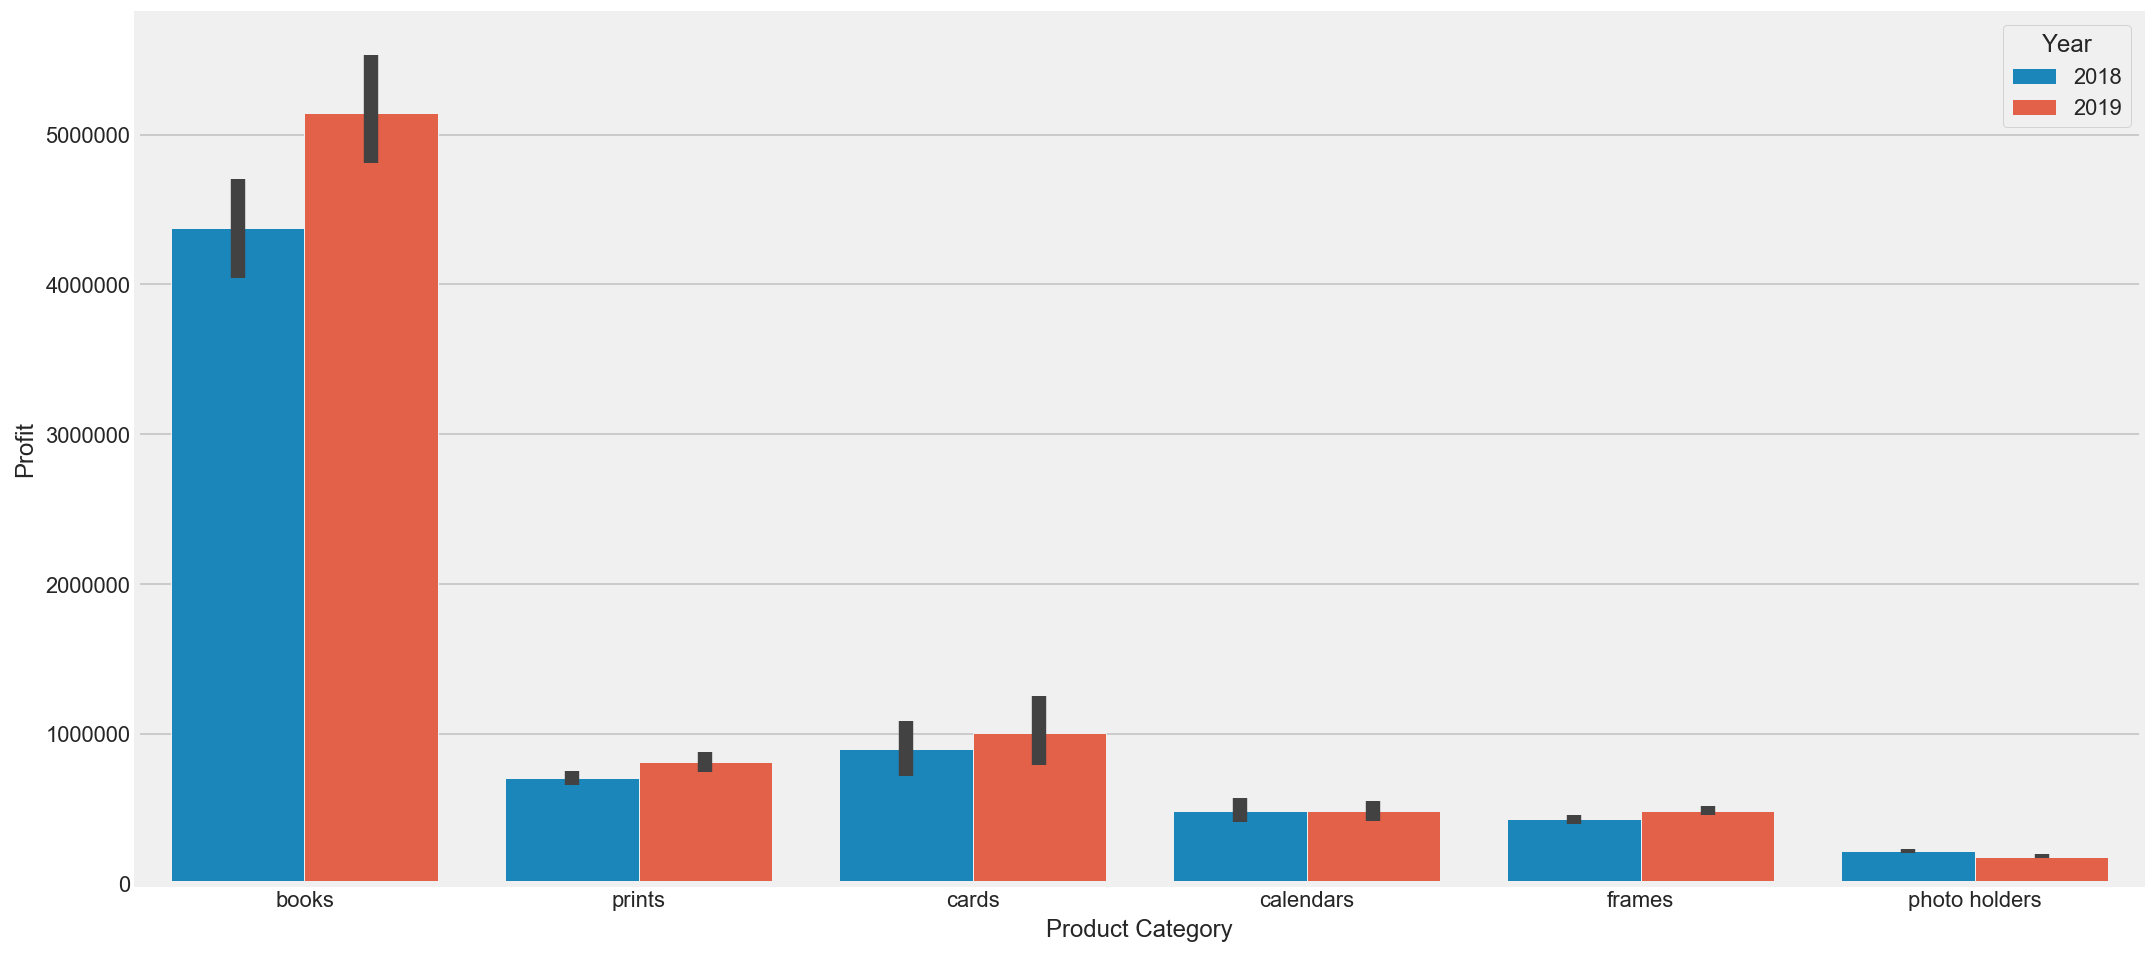

In [6]:
plt.figure(figsize=(16, 8))
sns.barplot(x='Product Category', y='Profit', hue='Year', estimator=np.sum, data=df)

# Year over Year Profit Ratio per Category

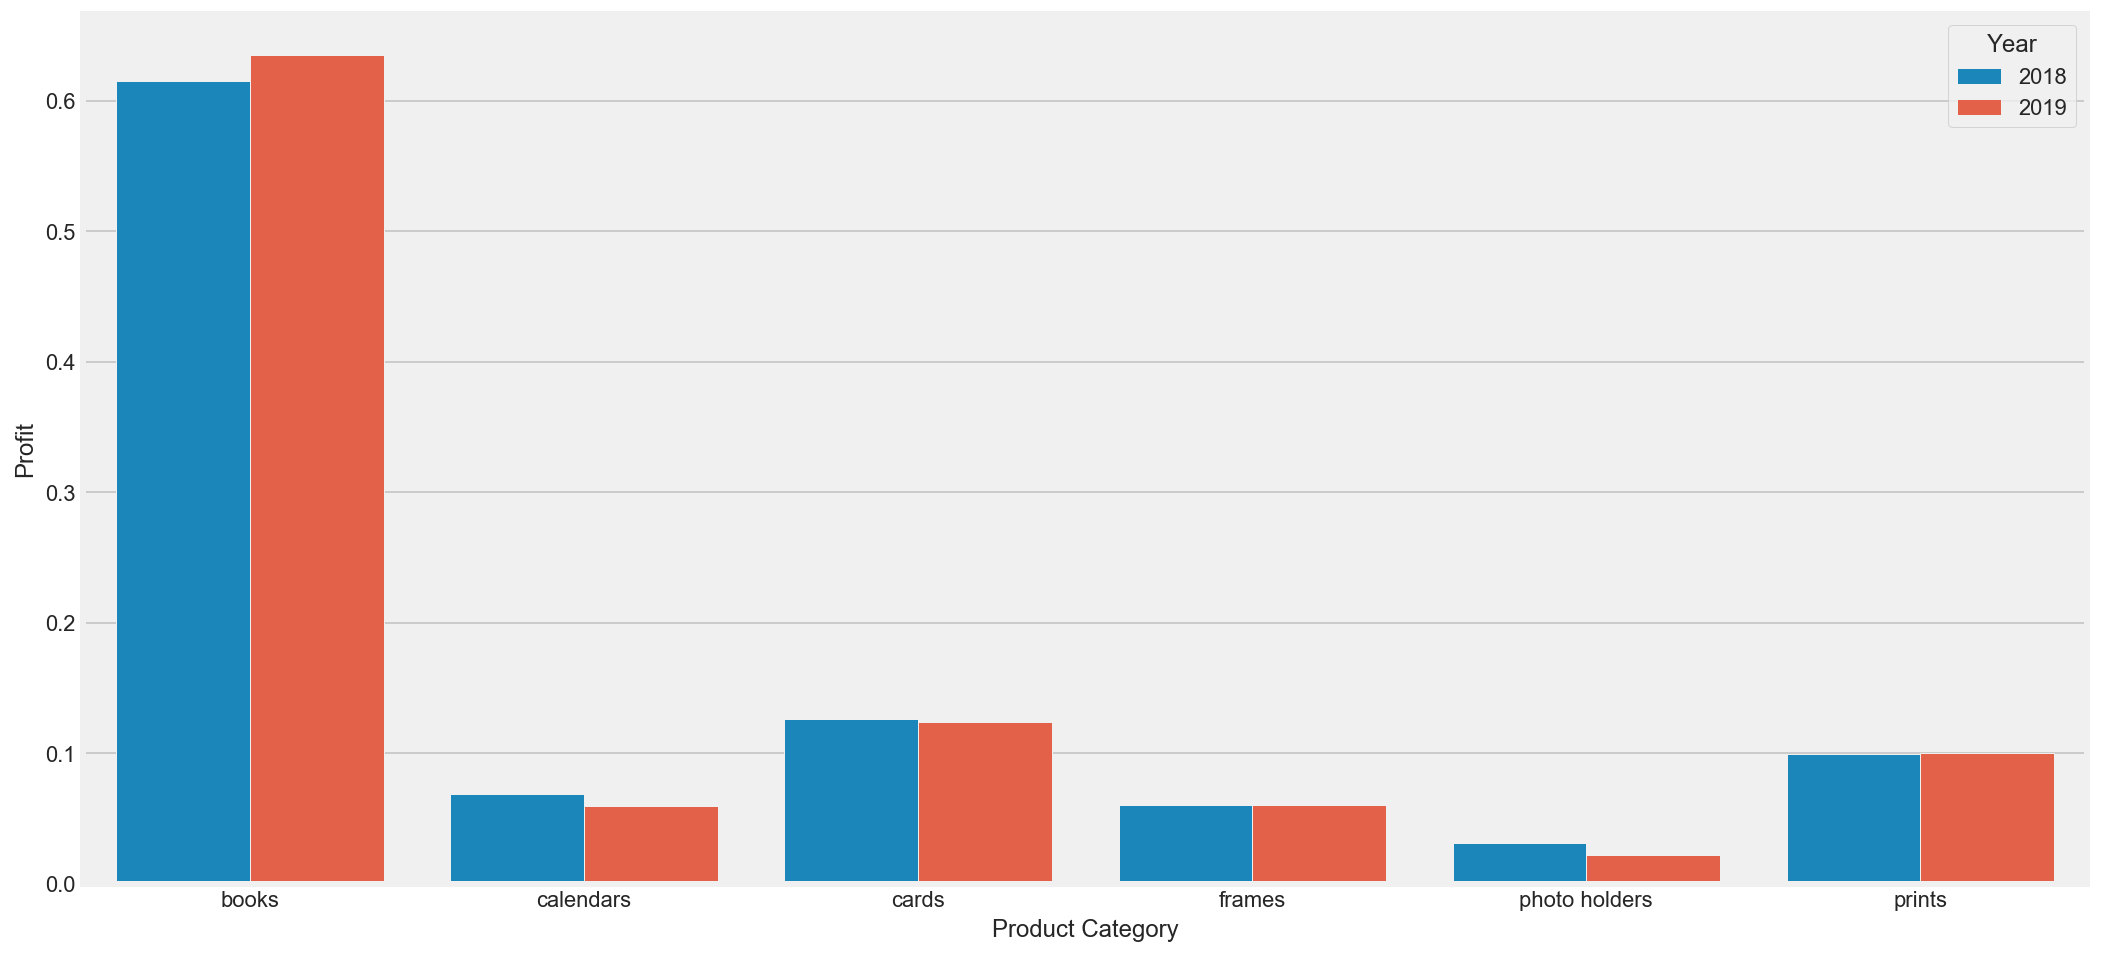

In [7]:
cat_rev = df.groupby(['Product Category','Year'])['Profit'].sum()
year_rev = df.groupby('Year')['Profit'].sum()
year_rev_ratio = cat_rev.div(year_rev).reset_index()
plt.figure(figsize=(16, 8))
sns.barplot(x='Product Category', y='Profit', hue='Year', data=year_rev_ratio)  

# 2019 Quarterly Profit by Product Category

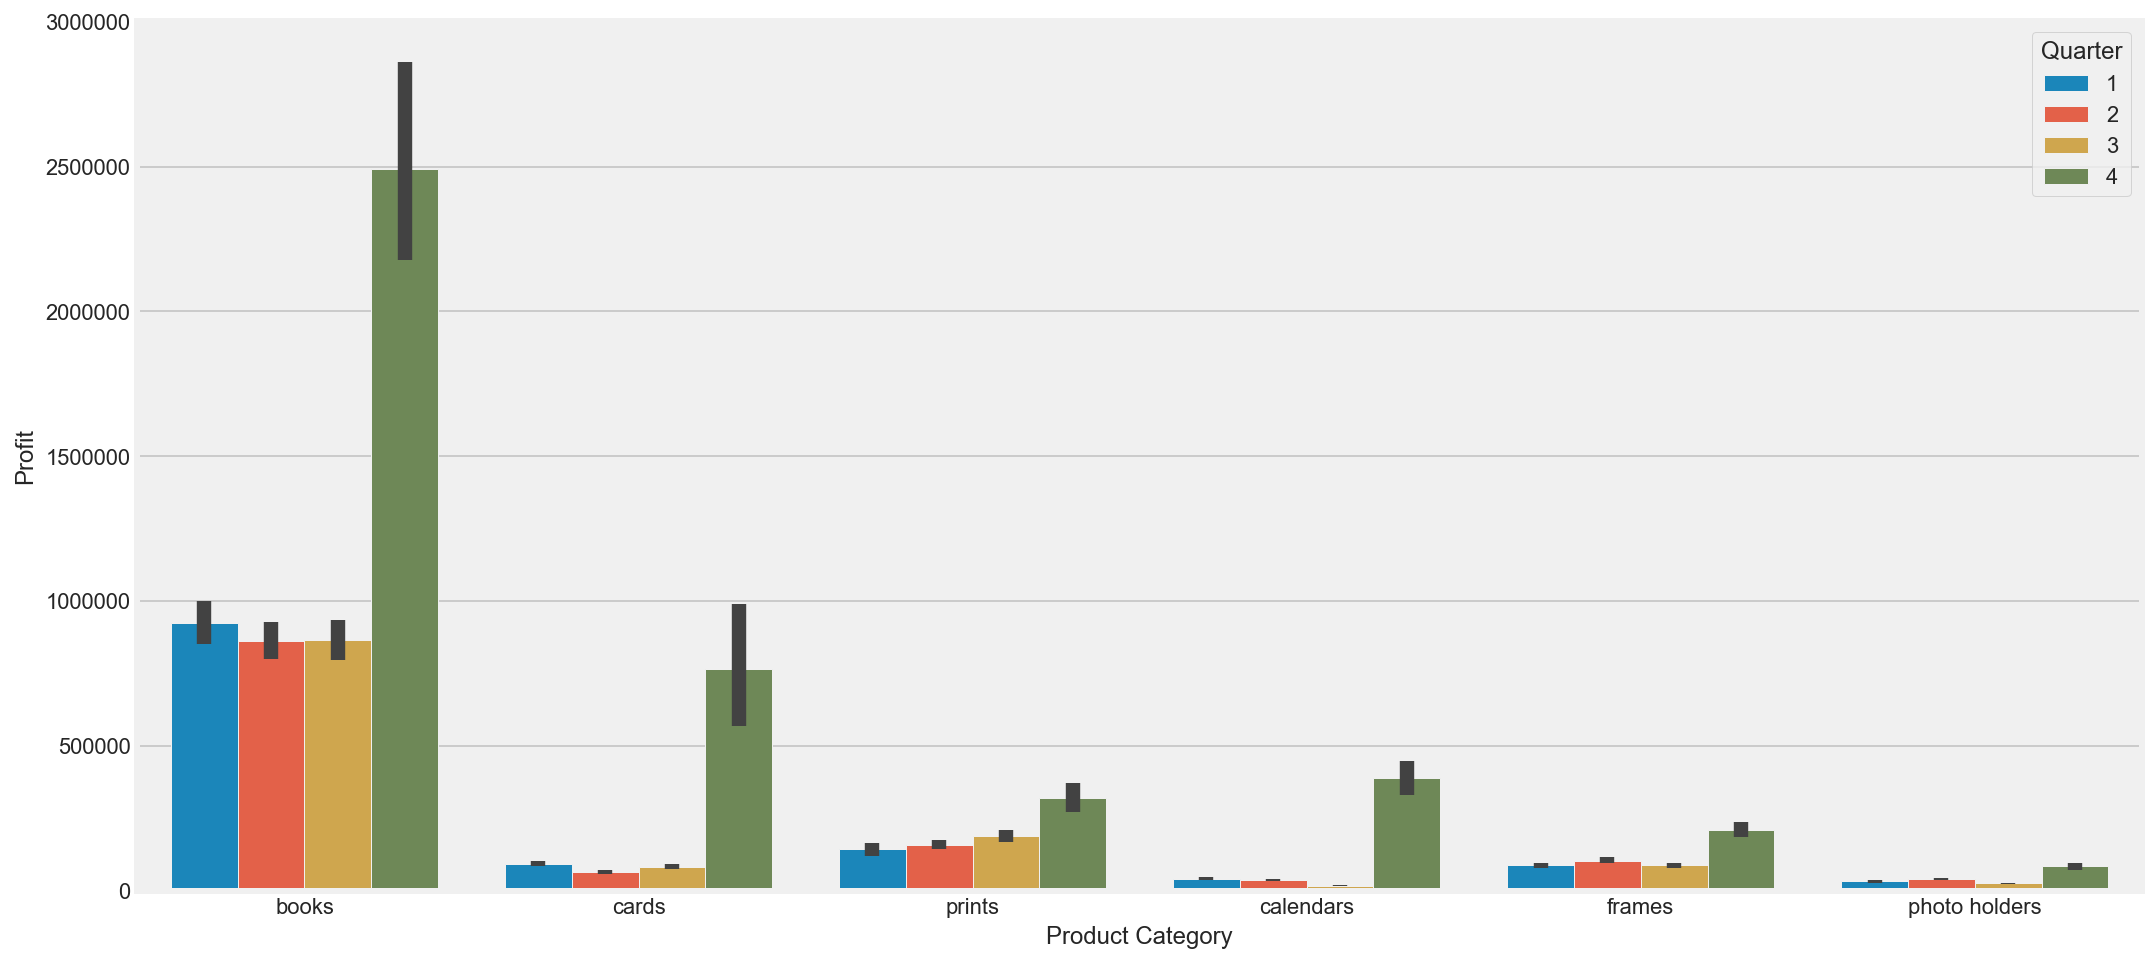

In [8]:
plt.figure(figsize=(16, 8))
sns.barplot(x='Product Category', y='Profit', hue='Quarter', estimator=np.sum, data=df[df['Year']==2019]) 

# Profit Distributions by Quarter and Product Category

In [9]:
q4_books_2019 = df[(df['Year']==2019)&(df['Product Category']=='books')&(df['Quarter']==4)].groupby(pd.Grouper(key='Date',freq='D'))['Profit'].sum().reset_index()
books_2019 = df[(df['Year']==2019)&(df['Product Category']=='books')].groupby([pd.Grouper(key='Date',freq='D'),'Quarter'])['Profit'].sum().reset_index()
q4_cards_2019 = df[(df['Year']==2019)&(df['Product Category']=='cards')&(df['Quarter']==4)].groupby(pd.Grouper(key='Date',freq='D'))['Profit'].sum().reset_index()
cards_2019 = df[(df['Year']==2019)&(df['Product Category']=='cards')].groupby([pd.Grouper(key='Date',freq='D'),'Quarter'])['Profit'].sum().reset_index()
q4_prints_2019 = df[(df['Year']==2019)&(df['Product Category']=='prints')&(df['Quarter']==4)].groupby(pd.Grouper(key='Date',freq='D'))['Profit'].sum().reset_index()
prints_2019 = df[(df['Year']==2019)&(df['Product Category']=='prints')].groupby([pd.Grouper(key='Date',freq='D'),'Quarter'])['Profit'].sum().reset_index()
q4_calendars_2019 = df[(df['Year']==2019)&(df['Product Category']=='calendars')&(df['Quarter']==4)].groupby(pd.Grouper(key='Date',freq='D'))['Profit'].sum().reset_index()
calendars_2019 = df[(df['Year']==2019)&(df['Product Category']=='calendars')].groupby([pd.Grouper(key='Date',freq='D'),'Quarter'])['Profit'].sum().reset_index()

# Books Profit Distribution by Quarter

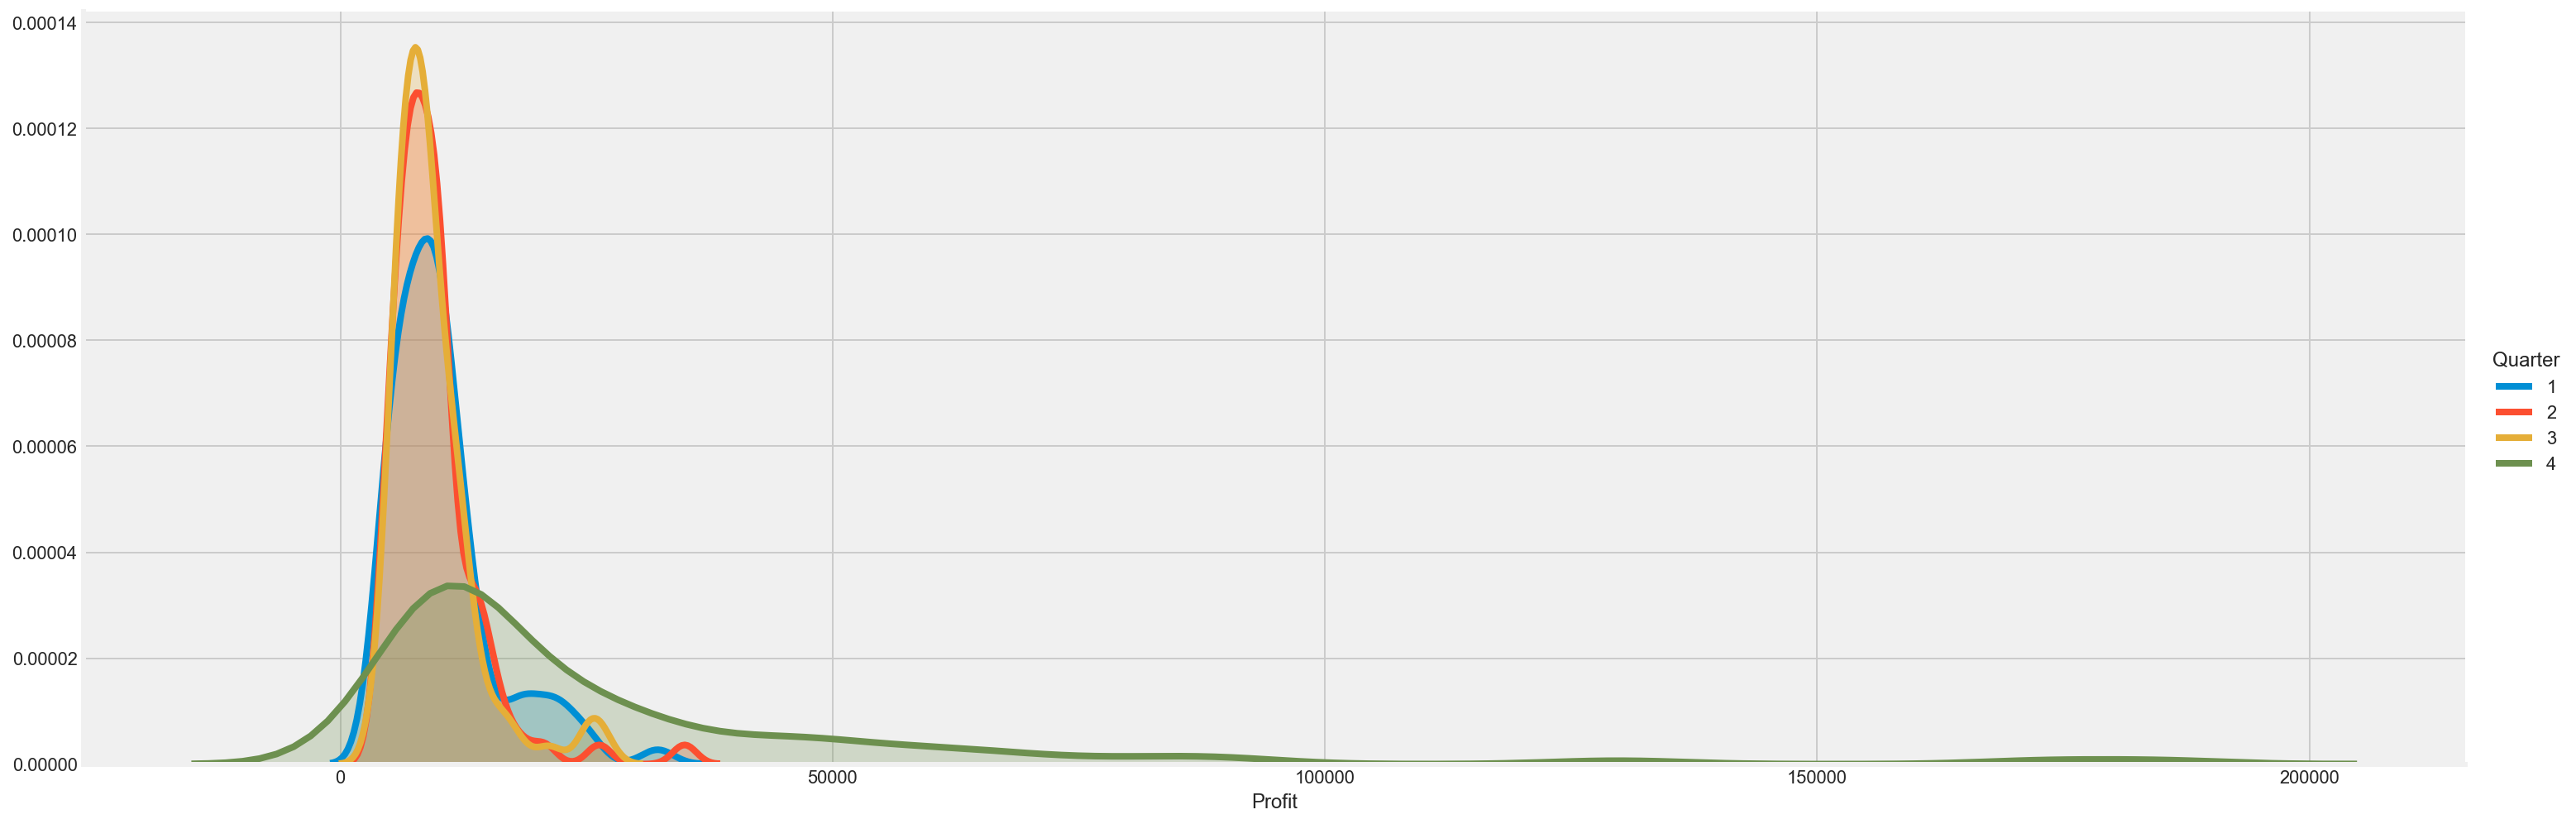

<Figure size 1152x576 with 0 Axes>

In [10]:
a = sns.FacetGrid(books_2019, hue = 'Quarter', height=7, aspect=3)
plt.figure(figsize=(16, 8))
a.map(sns.kdeplot, 'Profit', shade= True )
a.add_legend()

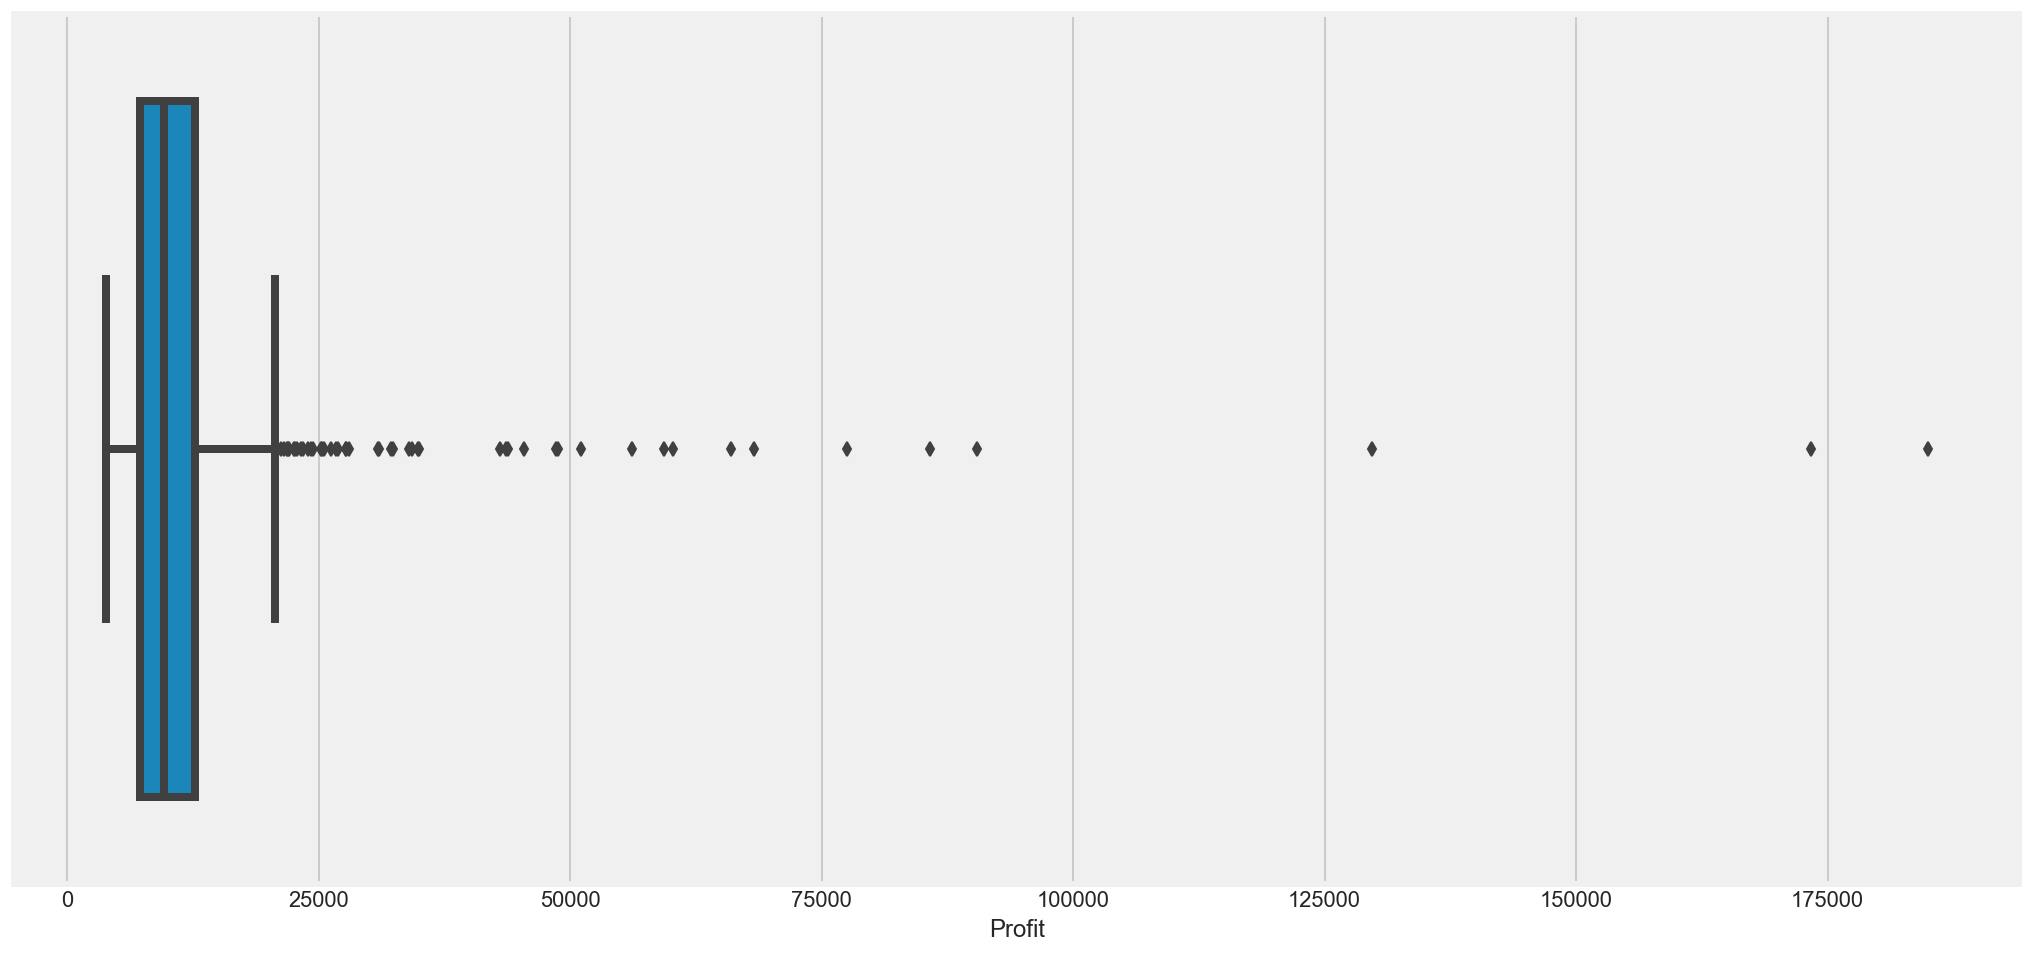

In [11]:
plt.figure(figsize=(16, 8))
sns.boxplot(books_2019['Profit'])

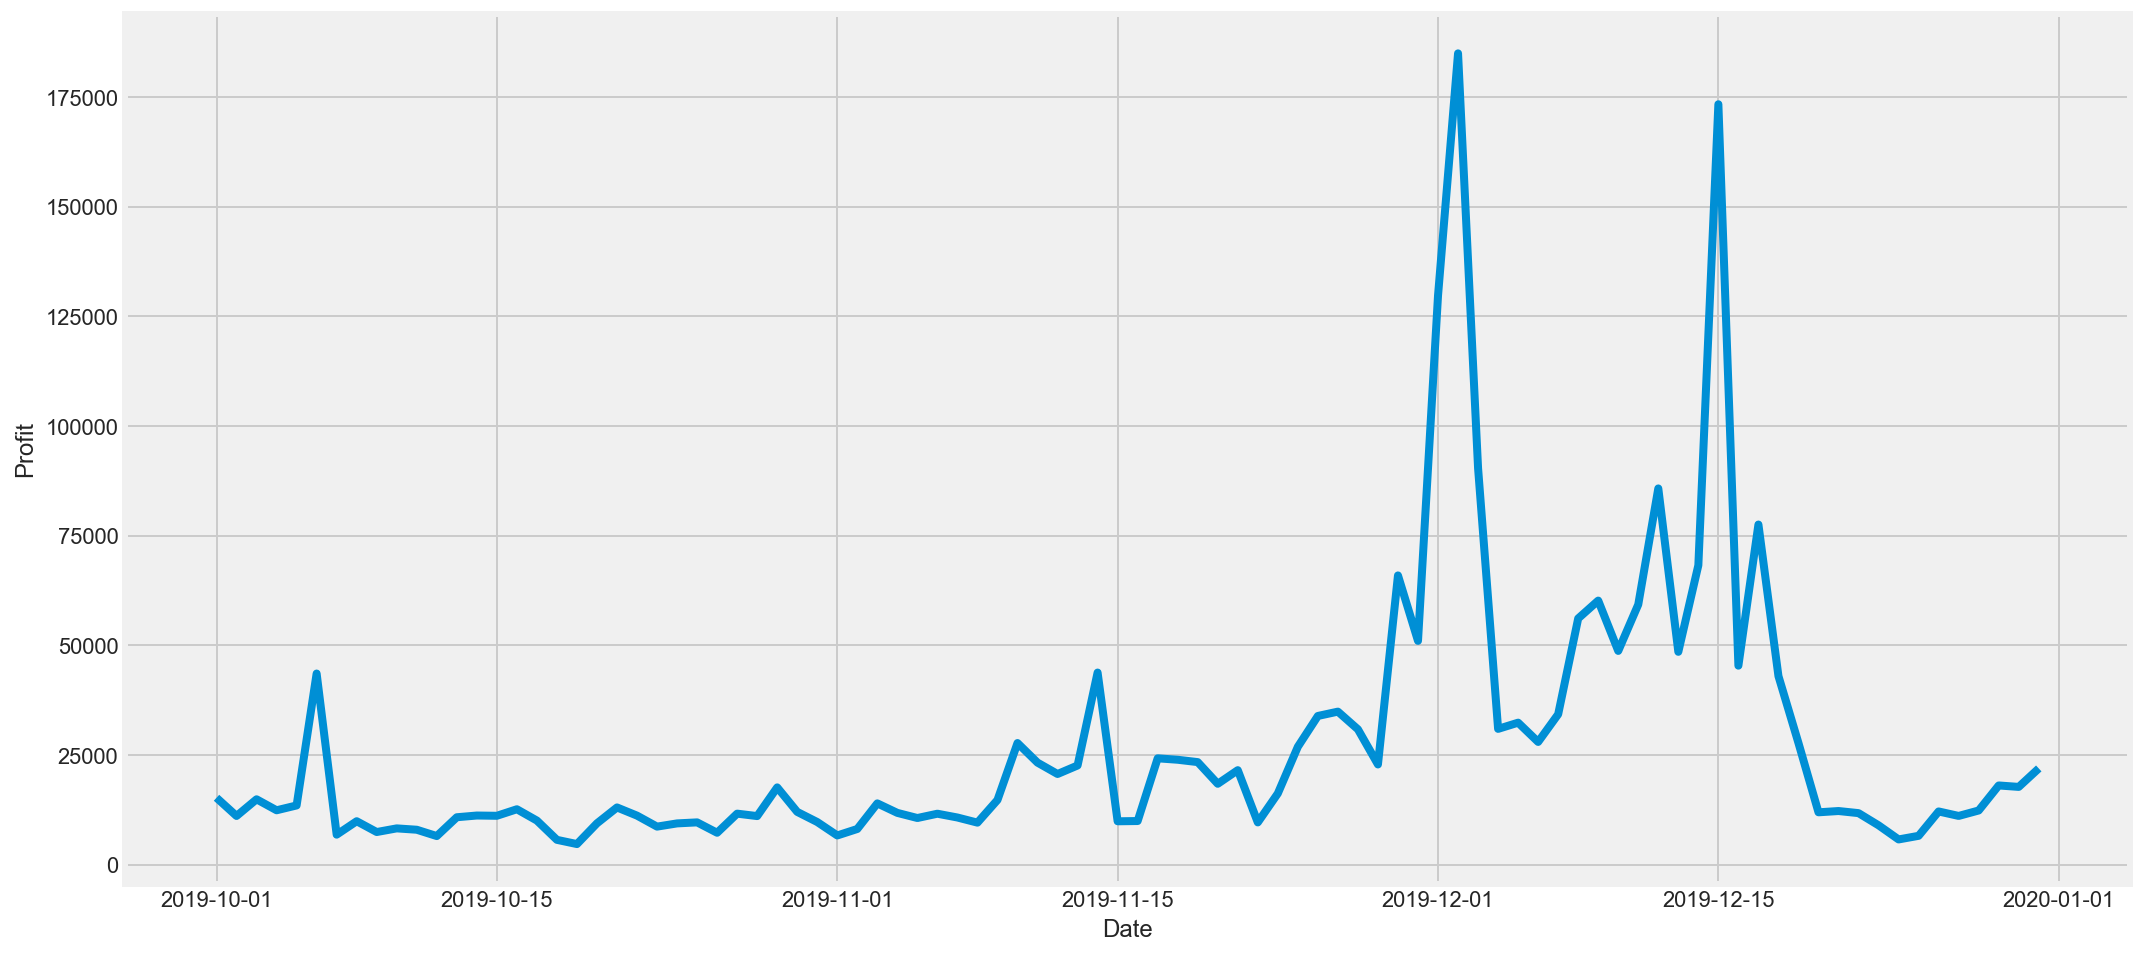

In [12]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='Date', y='Profit', data=q4_books_2019)

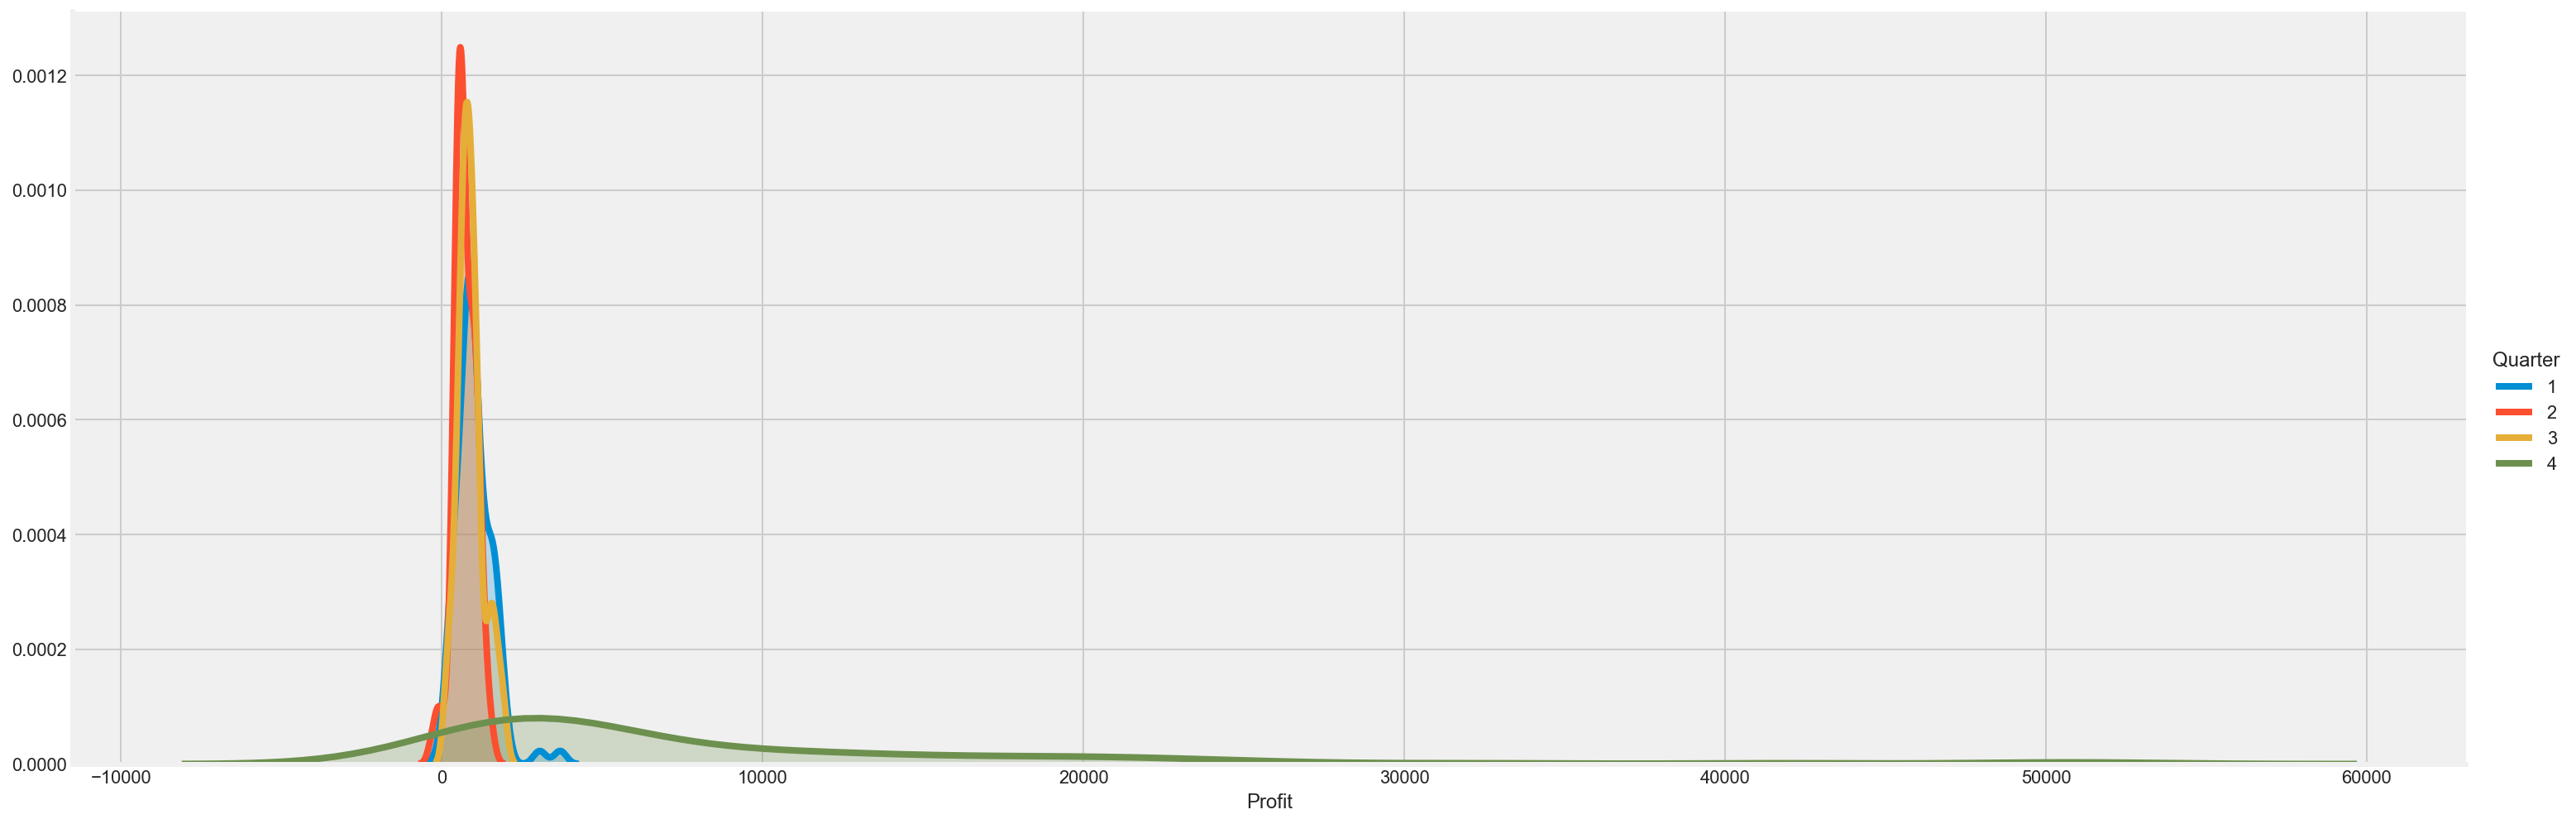

In [13]:
a = sns.FacetGrid(cards_2019, hue = 'Quarter', height=7, aspect=3)
a.map(sns.kdeplot, 'Profit', shade= True )
a.add_legend()

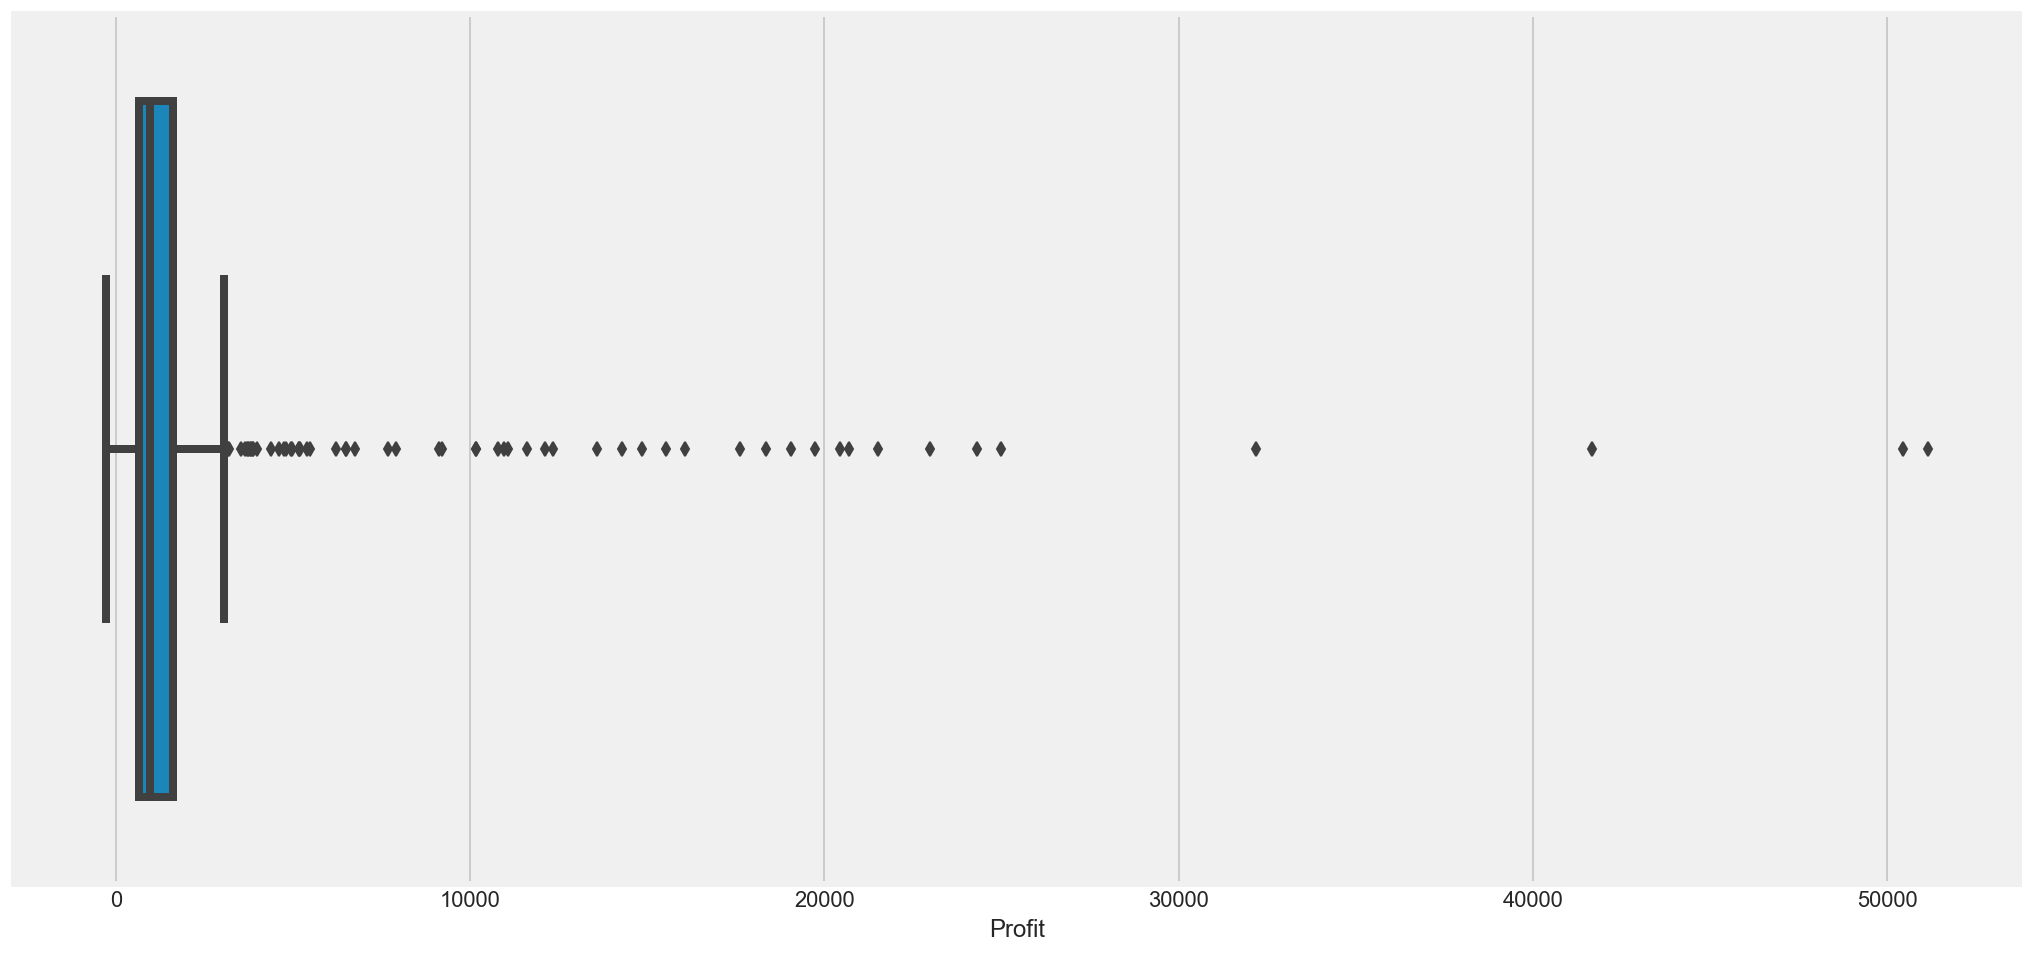

In [14]:
plt.figure(figsize=(16, 8))
sns.boxplot(cards_2019['Profit'])

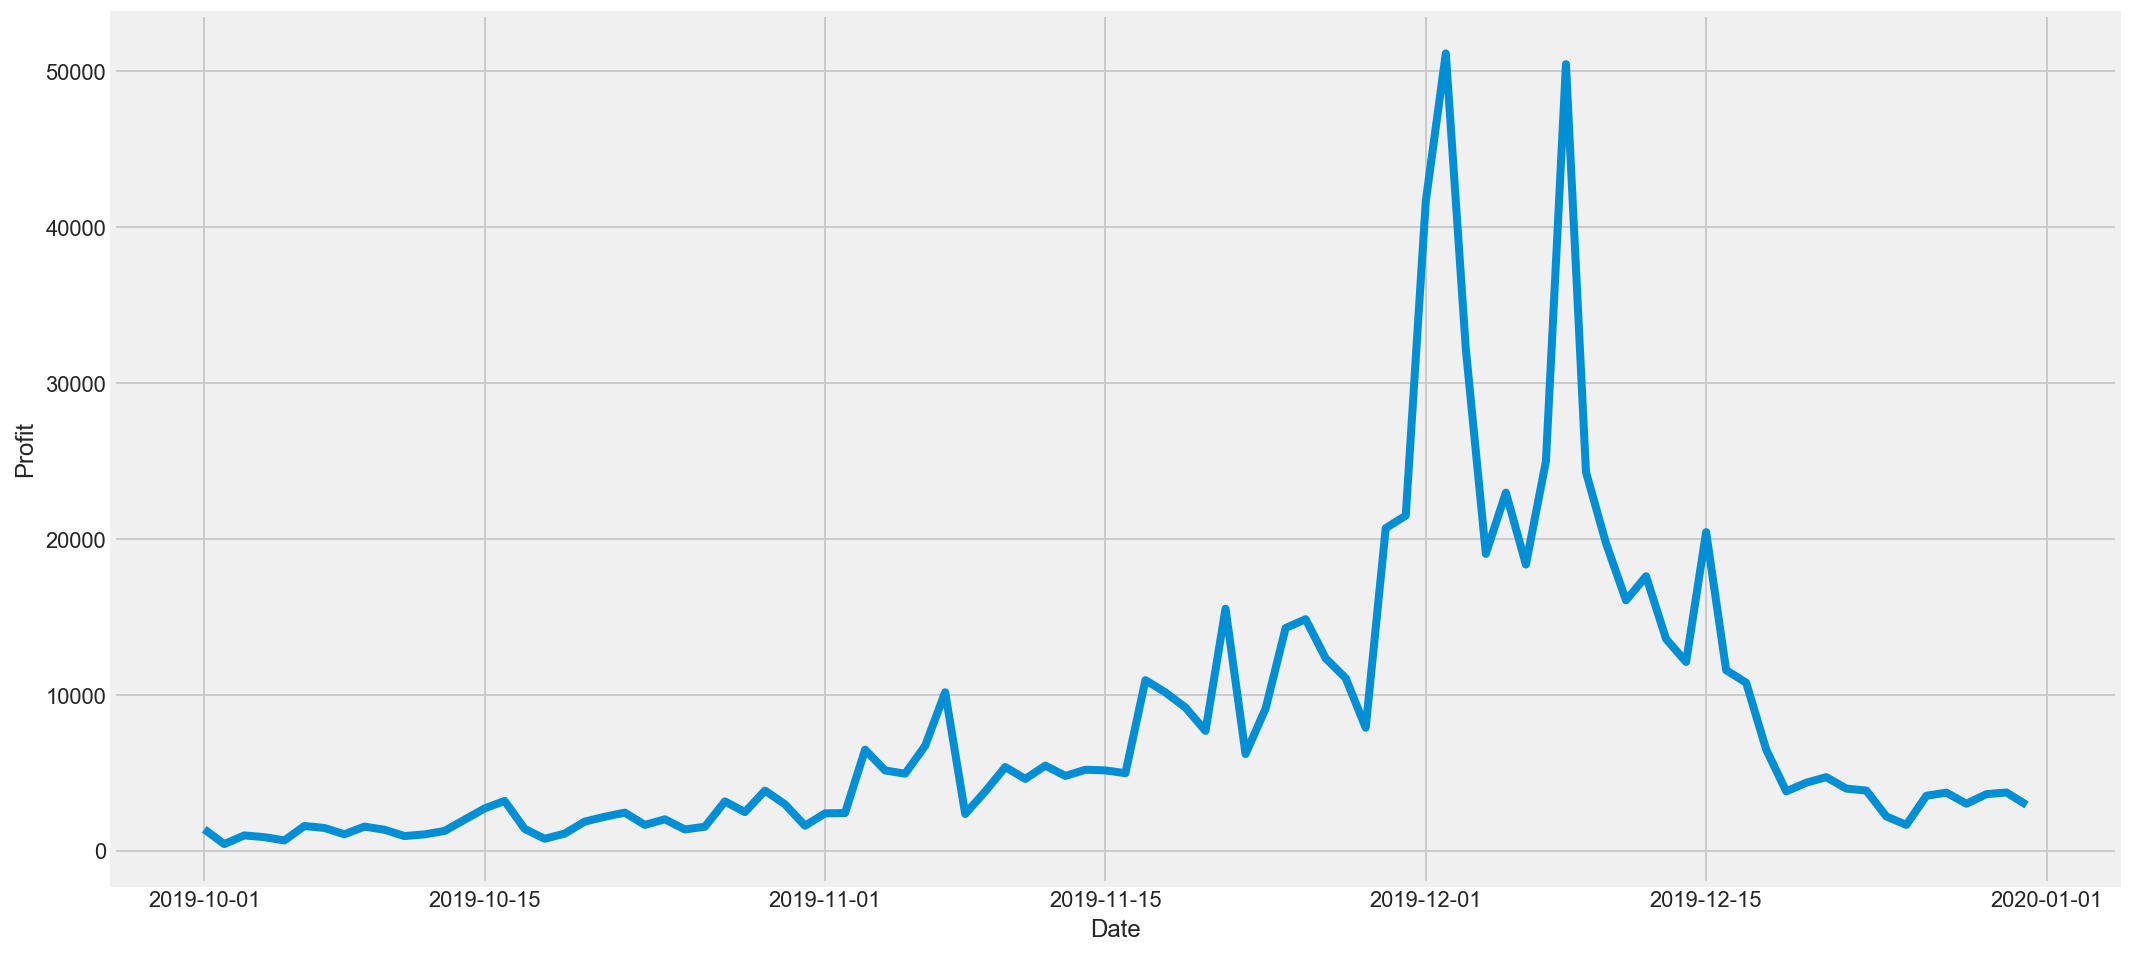

In [15]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='Date', y='Profit', data=q4_cards_2019)

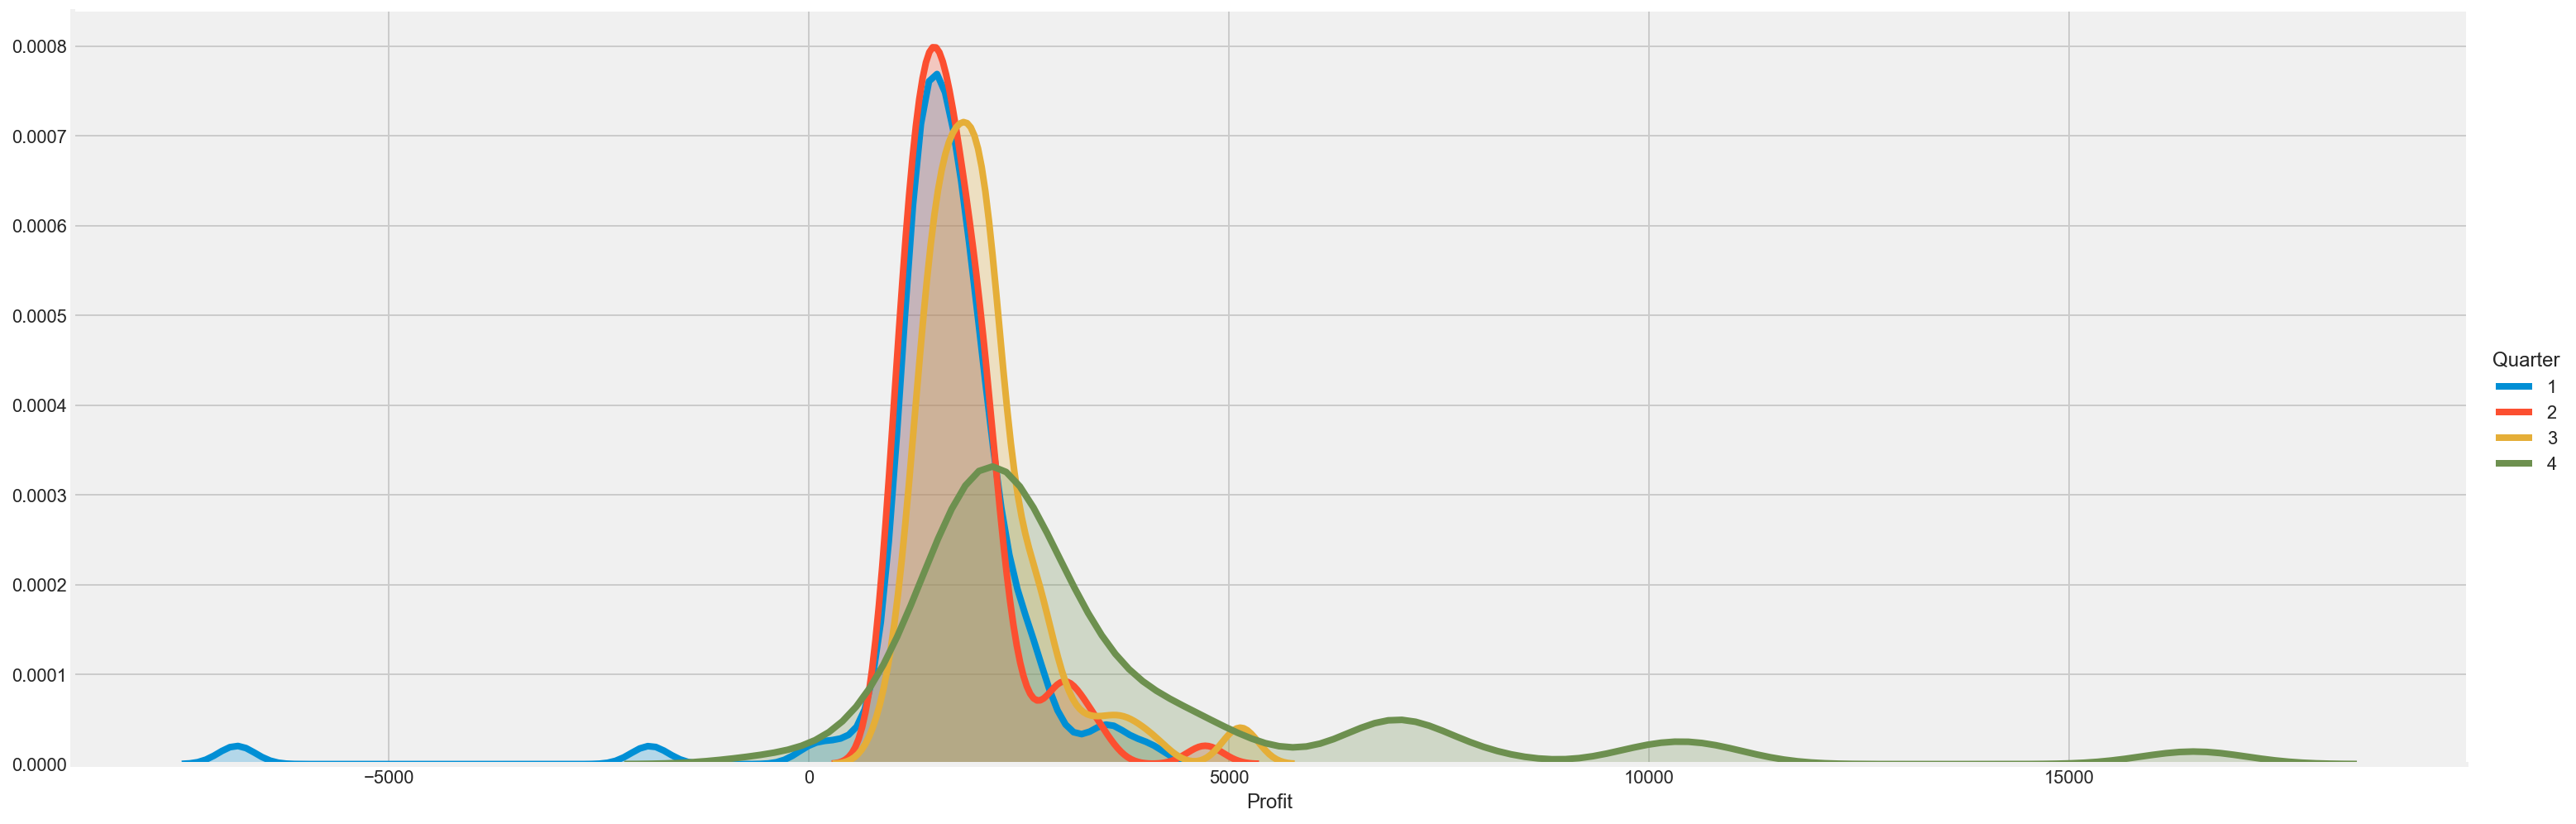

In [16]:
a = sns.FacetGrid(prints_2019, hue = 'Quarter', height=7, aspect=3)
a.map(sns.kdeplot, 'Profit', shade= True )
a.add_legend()

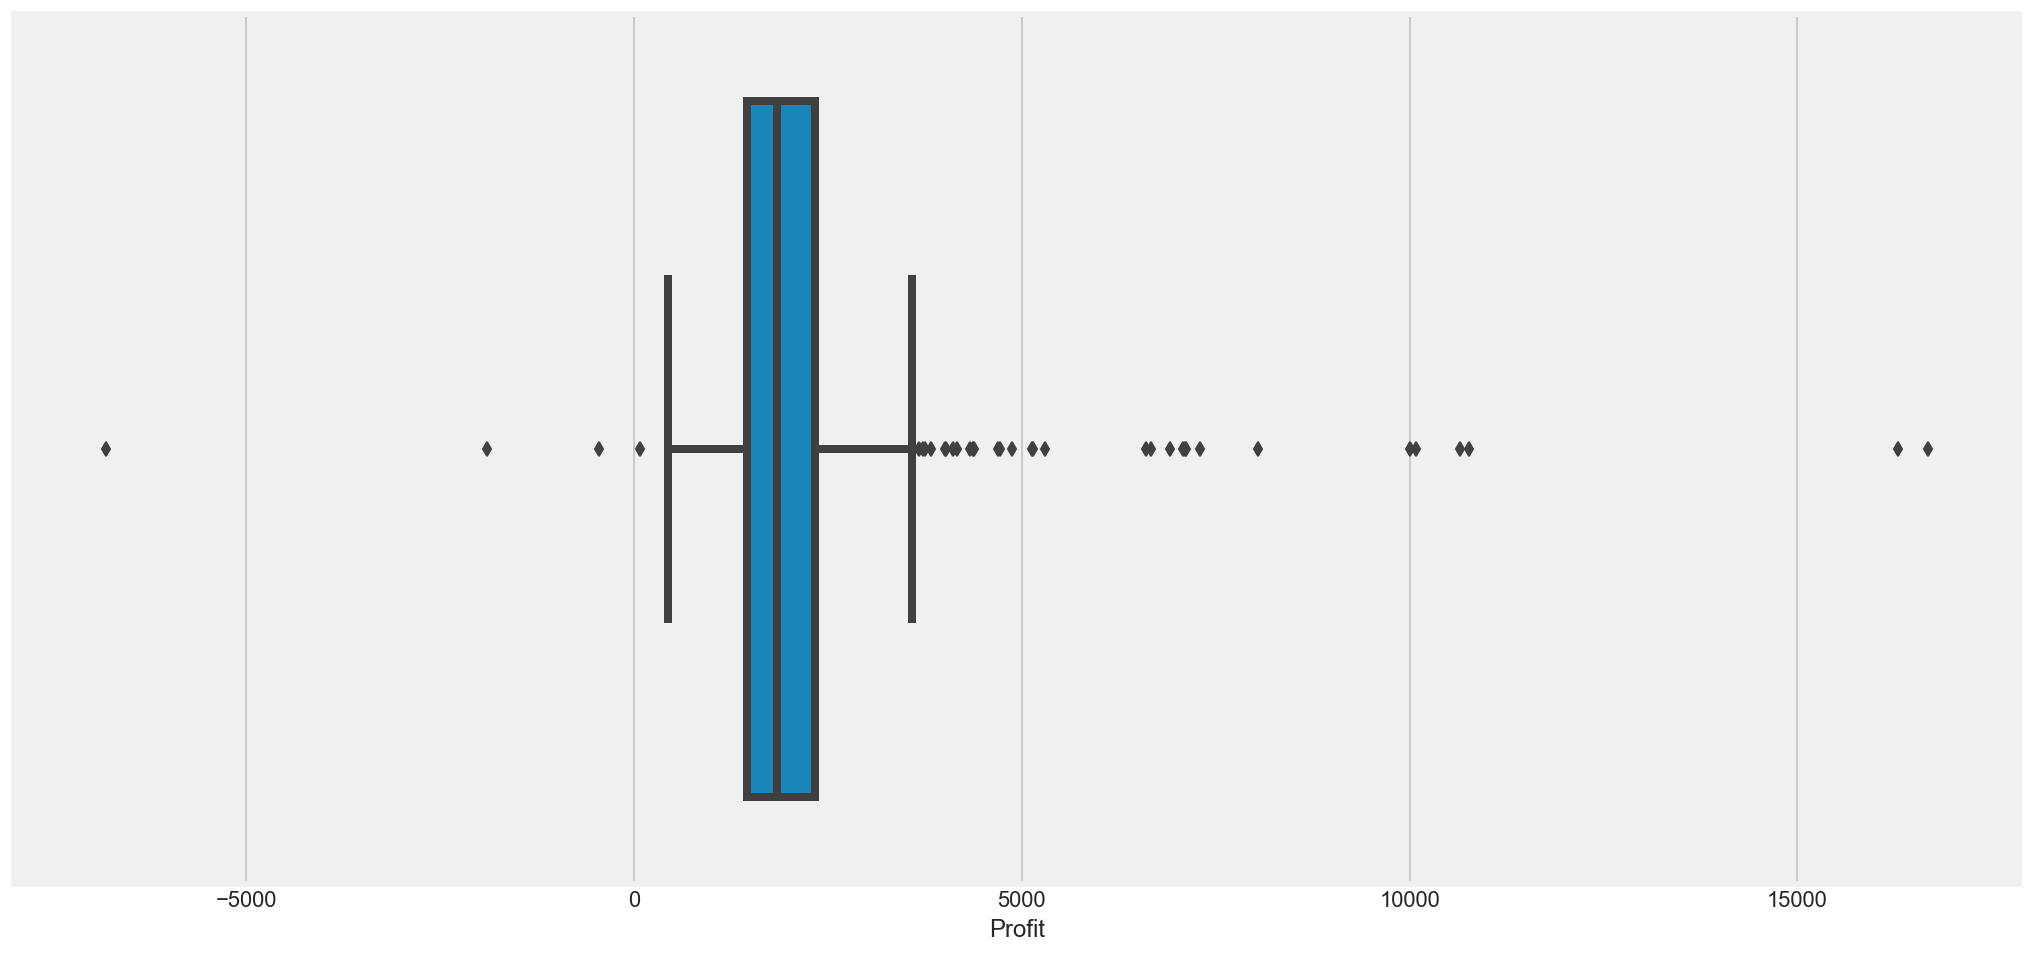

In [17]:
plt.figure(figsize=(16, 8))
sns.boxplot(prints_2019['Profit'])

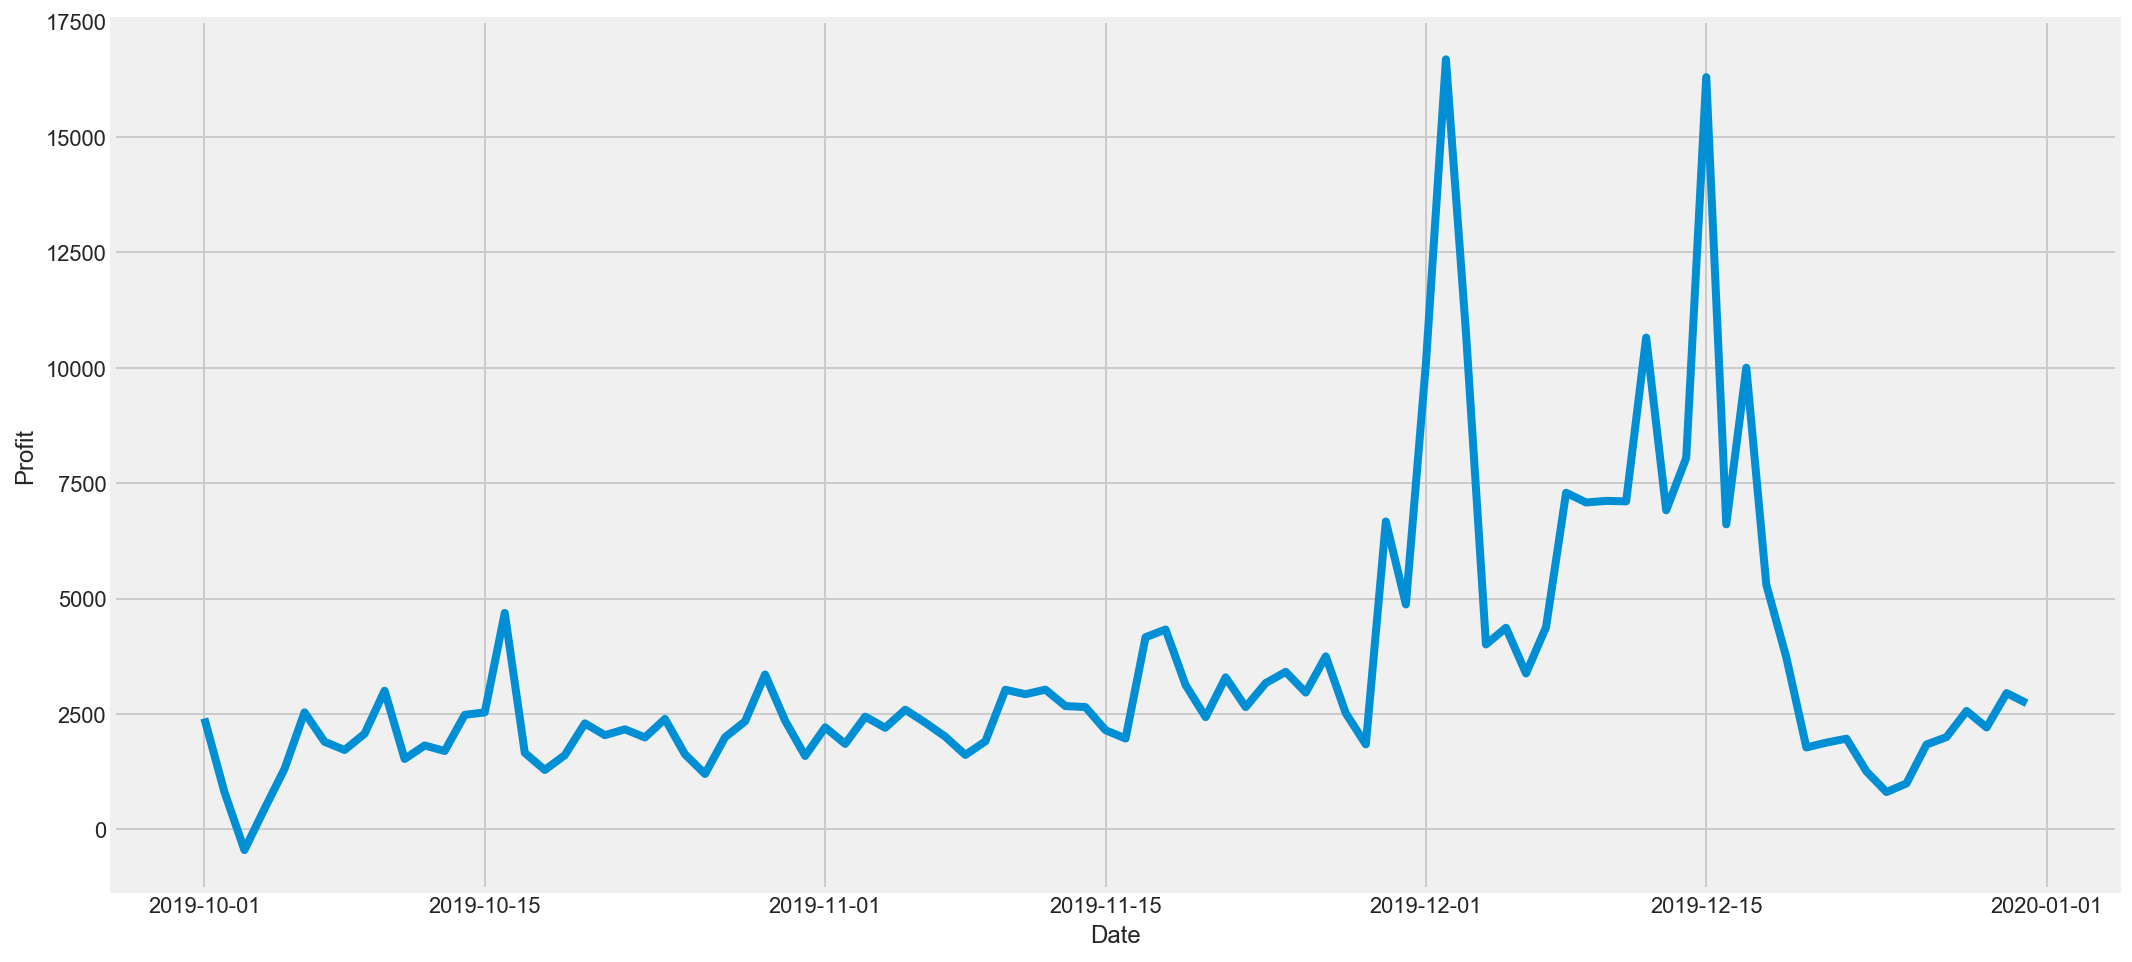

In [18]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='Date', y='Profit', data=q4_prints_2019)

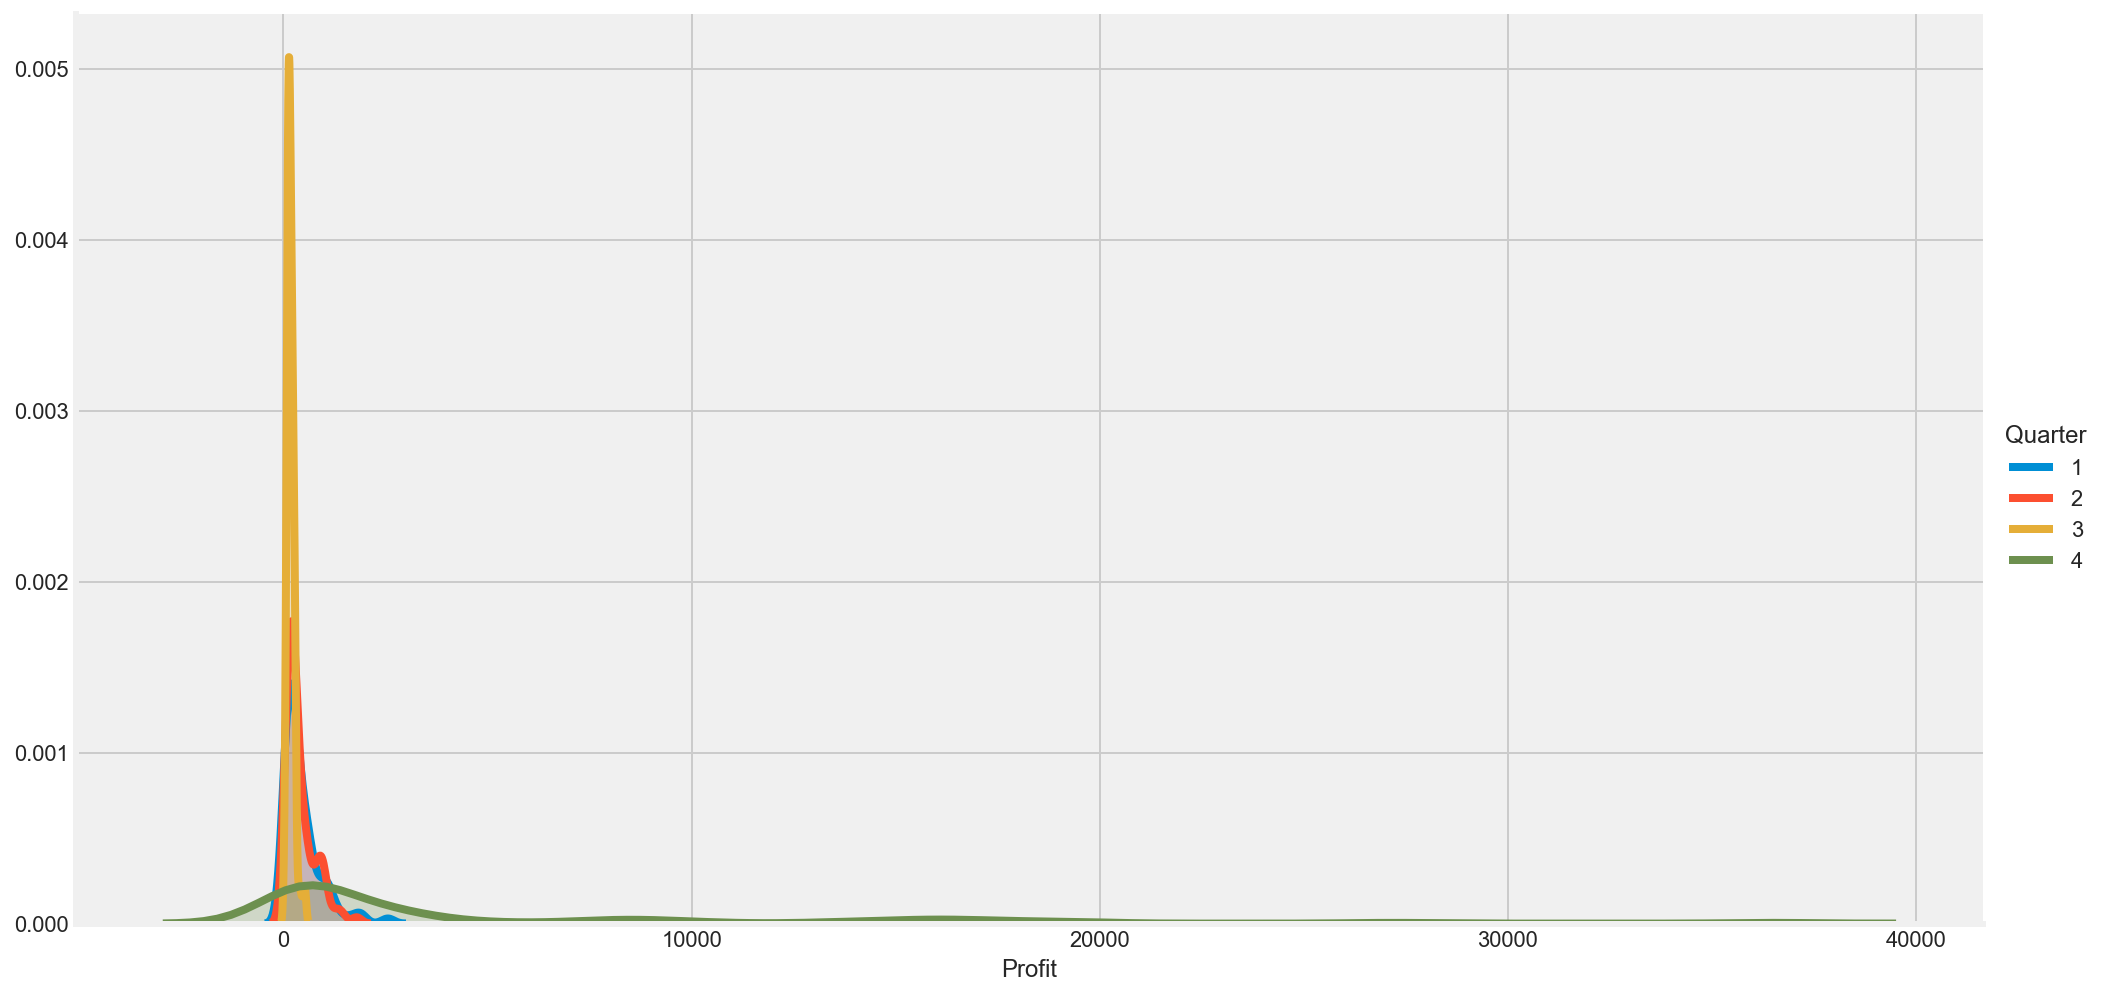

In [19]:
a = sns.FacetGrid(calendars_2019, hue = 'Quarter', height=7, aspect=2)
a.map(sns.kdeplot, 'Profit', shade= True )
a.add_legend()

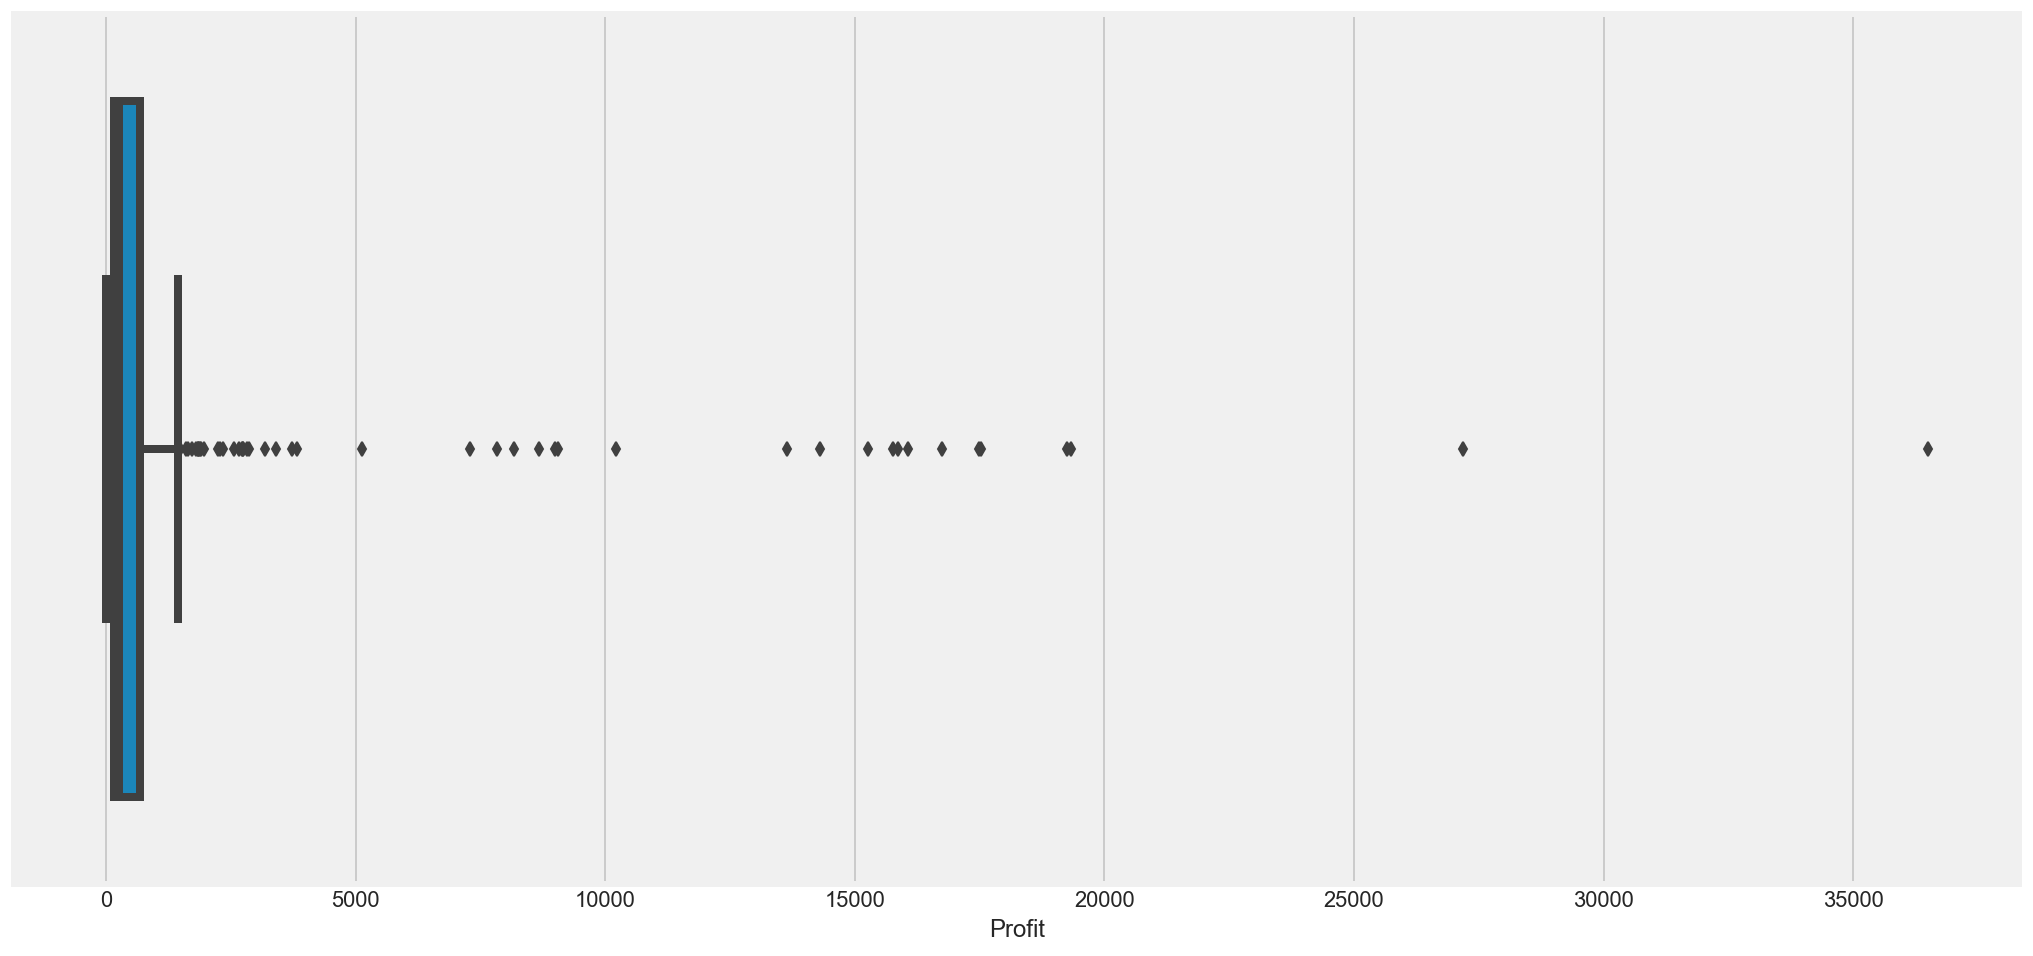

In [20]:
plt.figure(figsize=(16, 8))
sns.boxplot(calendars_2019['Profit'])

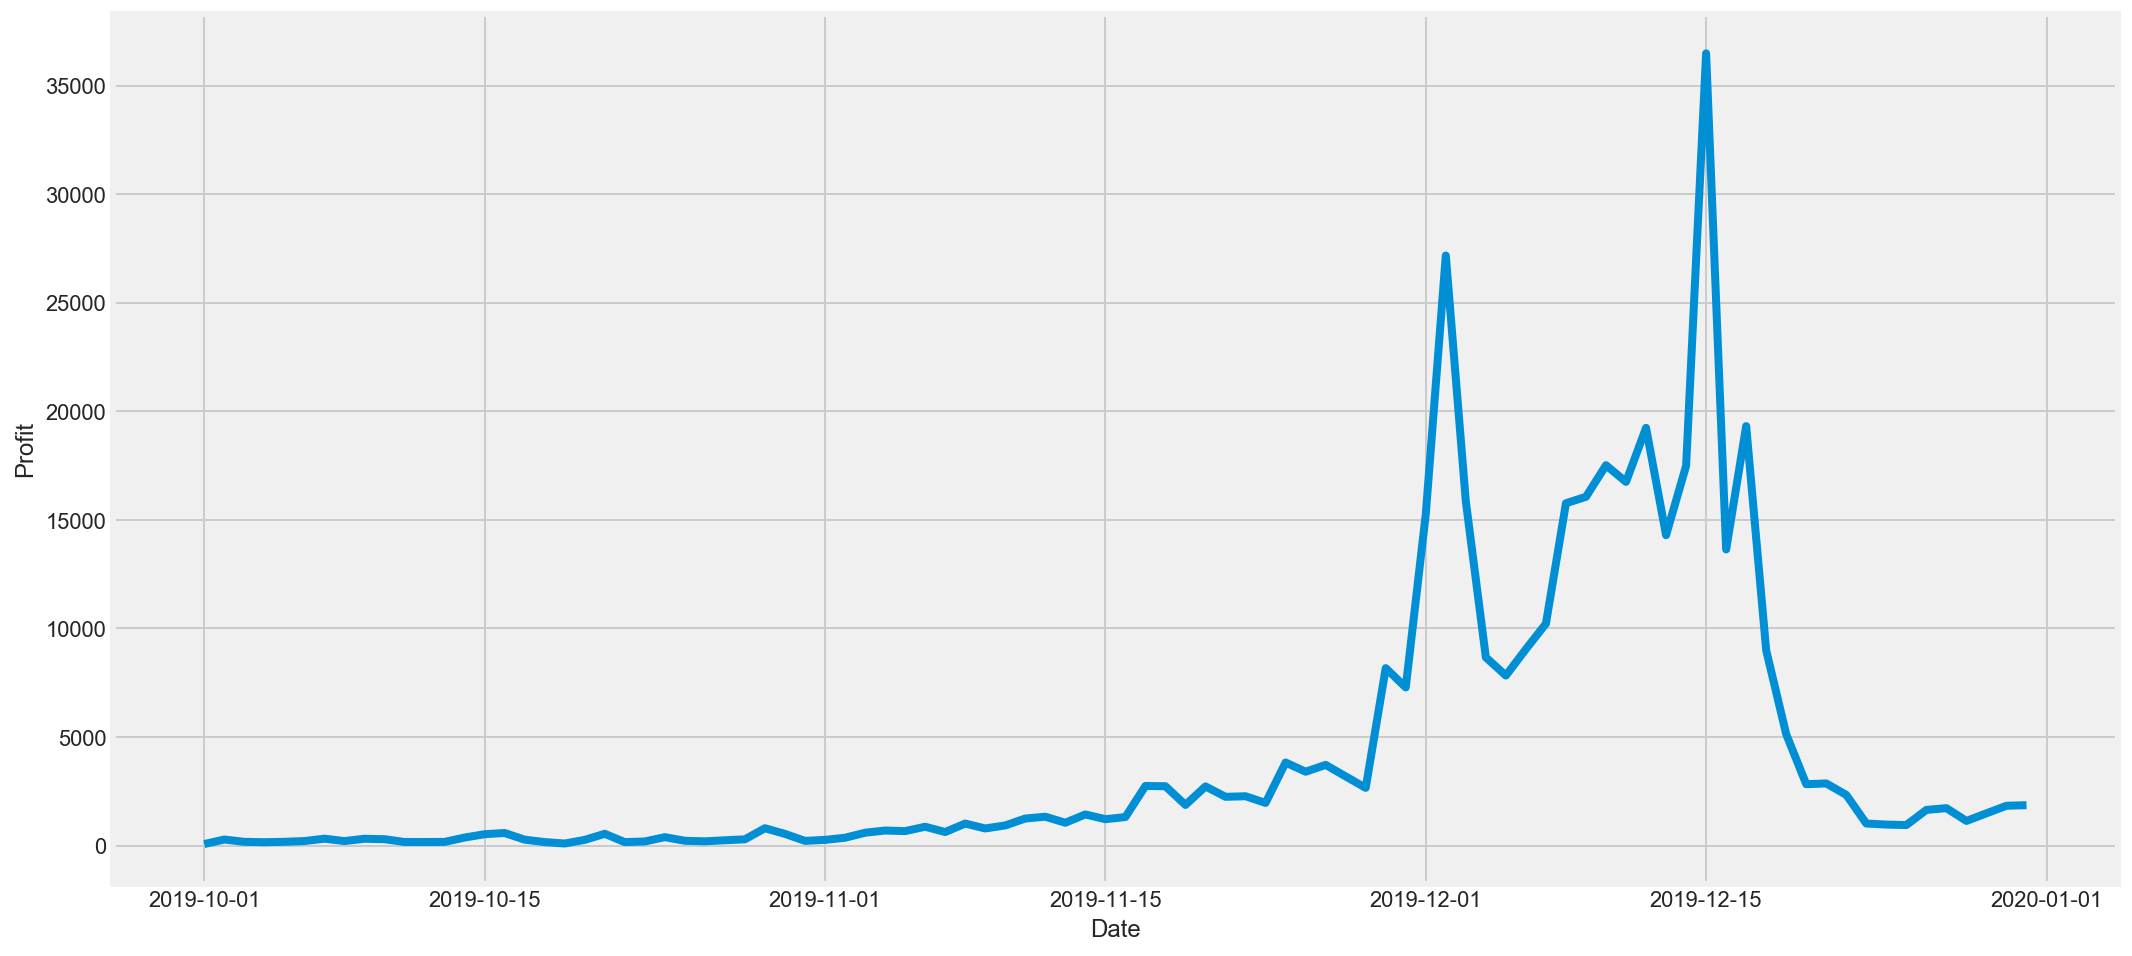

In [21]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='Date', y='Profit', data=q4_calendars_2019)

# Correlation Matrix

In [22]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

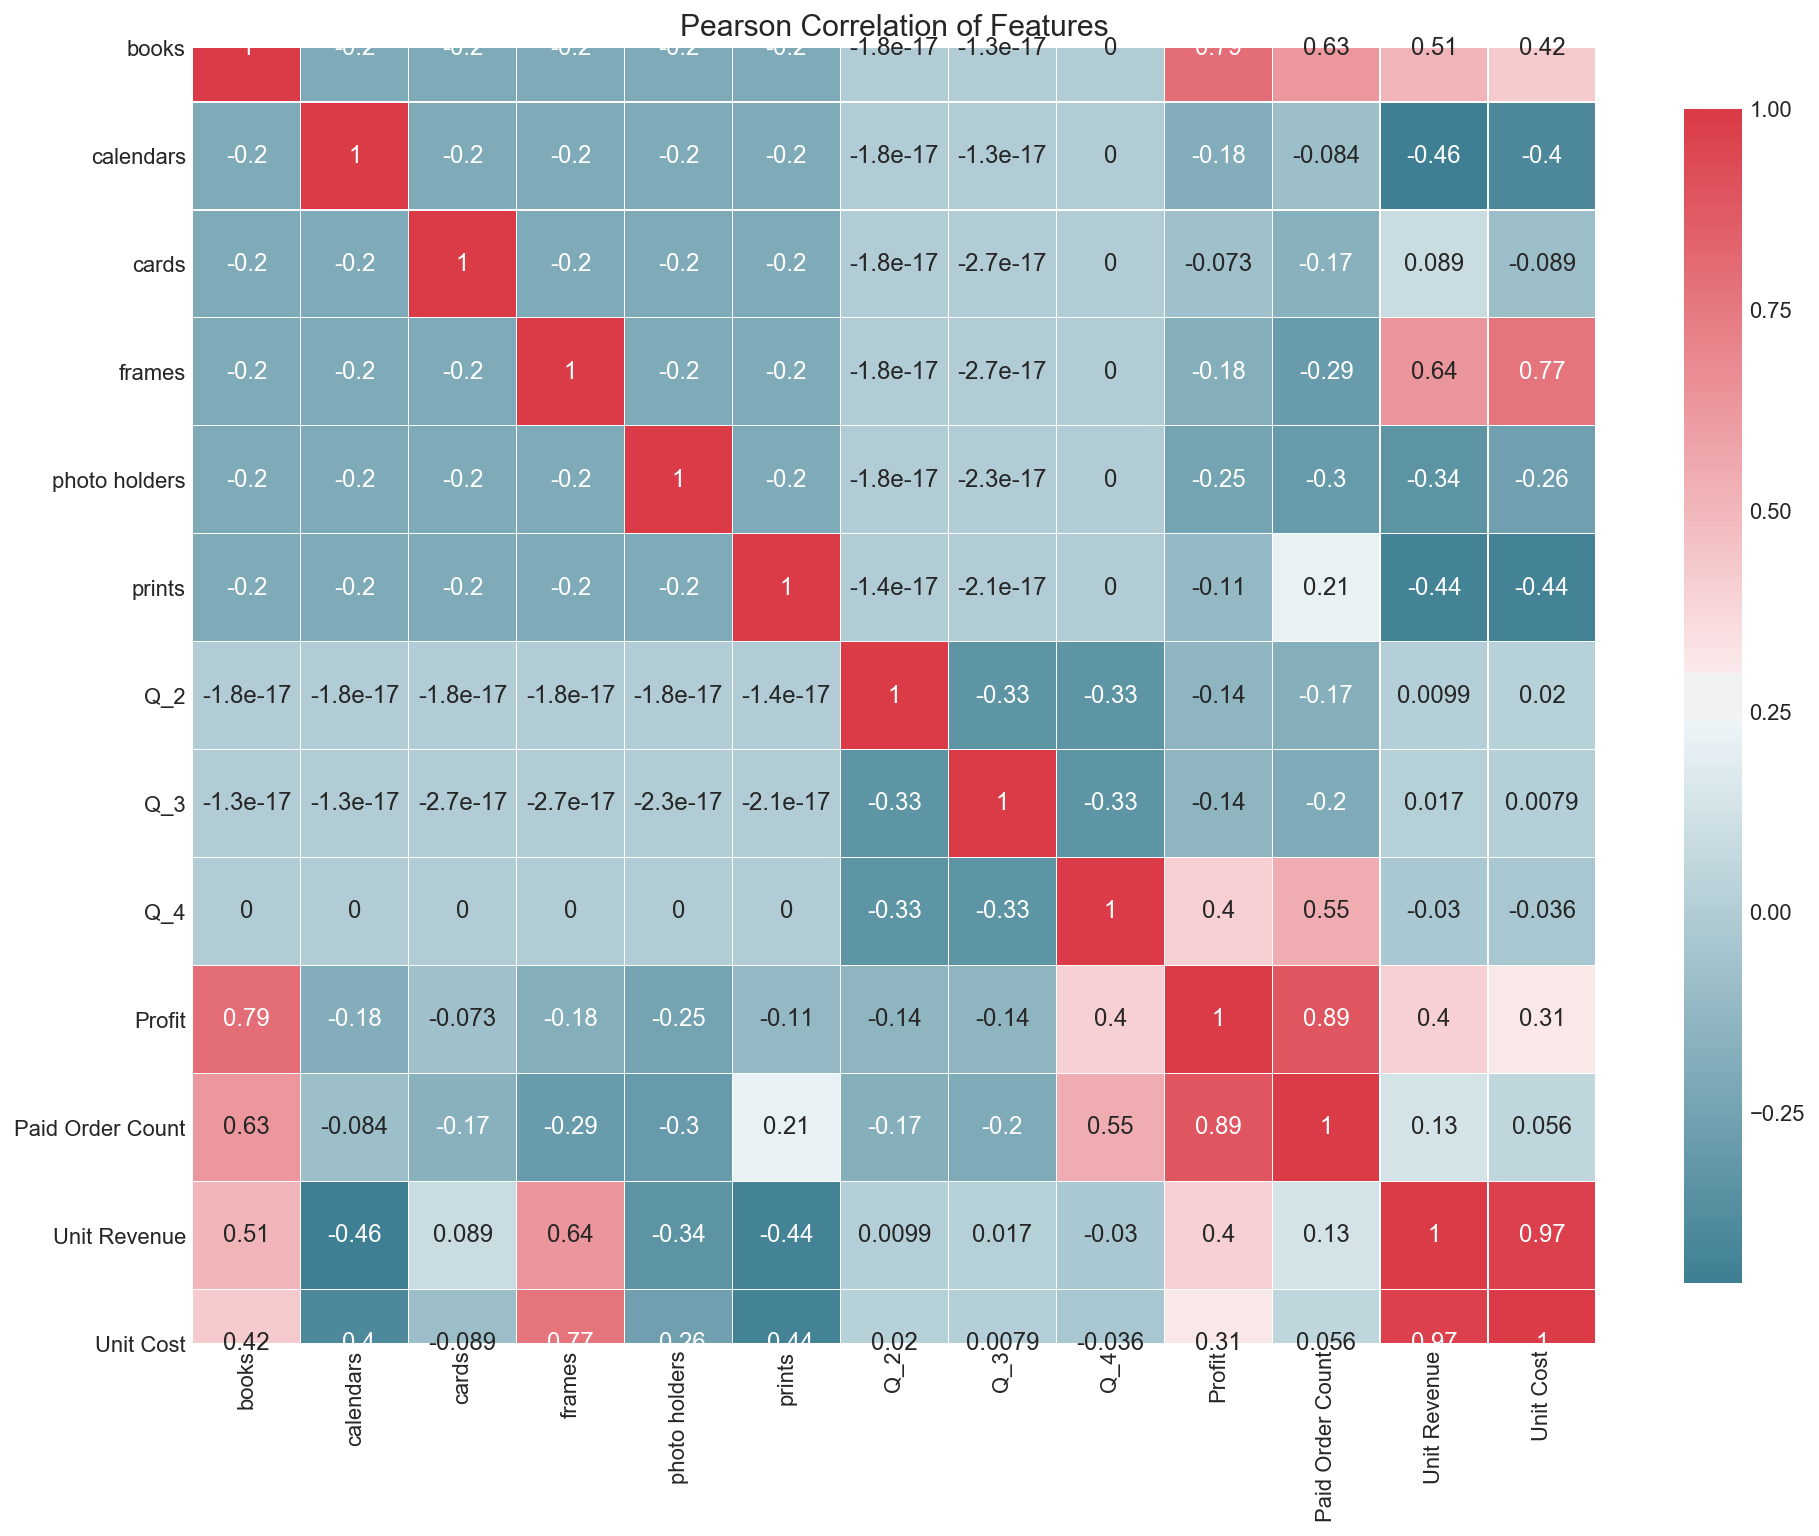

In [23]:
corr_df = df[df['Year']==2019].groupby(['Product Category','Quarter']).agg({'Profit':np.sum, 'Paid Order Count':np.sum,'Unit Revenue':np.mean, 'Unit Cost':np.mean}).reset_index()
quarter_dummies = pd.get_dummies(corr_df['Quarter'], prefix='Q', drop_first=True)
cat_dummies = pd.get_dummies(corr_df['Product Category'], drop_first=False)
corr_df = pd.concat([cat_dummies,quarter_dummies, corr_df[['Profit','Paid Order Count','Unit Revenue','Unit Cost']]], axis=1)
correlation_heatmap(corr_df)

# Time Series & Trend Analysis

In [24]:
daily_profit = df.groupby(['Product Category', pd.Grouper(key='Date',freq='D')])['Profit'].sum().reset_index()
daily_profit['Rolling Profit'] = daily_profit['Profit'].rolling(window=7).mean()

In [27]:
daily_rev = df.groupby(['Product Category', pd.Grouper(key='Date',freq='D')])['Net Total Revenue'].sum().reset_index()
daily_rev['Rolling Rev'] = daily_rev['Net Total Revenue'].rolling(window=7).mean()

In [28]:
daily_orders = df.groupby(['Product Category', pd.Grouper(key='Date',freq='D')])['Paid Order Count'].sum().reset_index()
daily_orders['Rolling Orders'] = daily_orders['Paid Order Count'].rolling(window=7).mean()

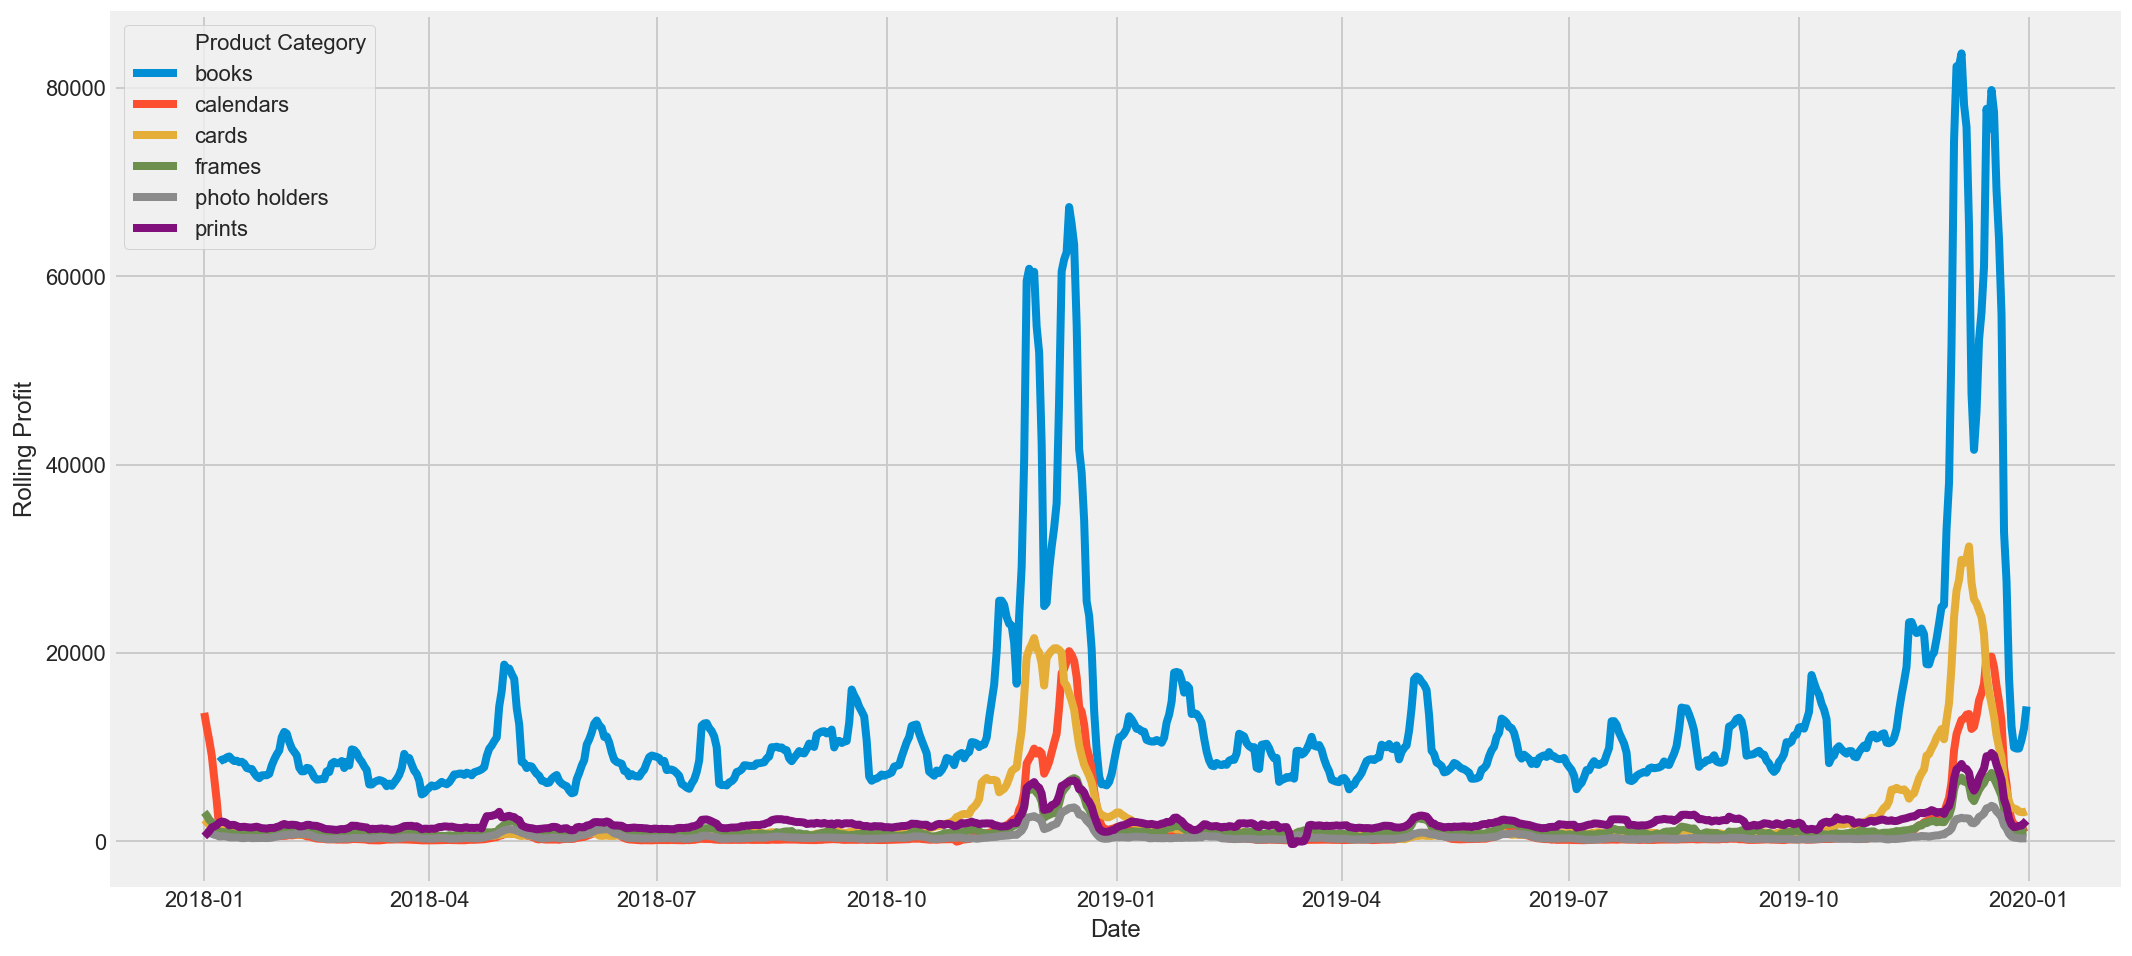

In [29]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='Date',y='Rolling Profit', hue='Product Category', data=daily_profit)

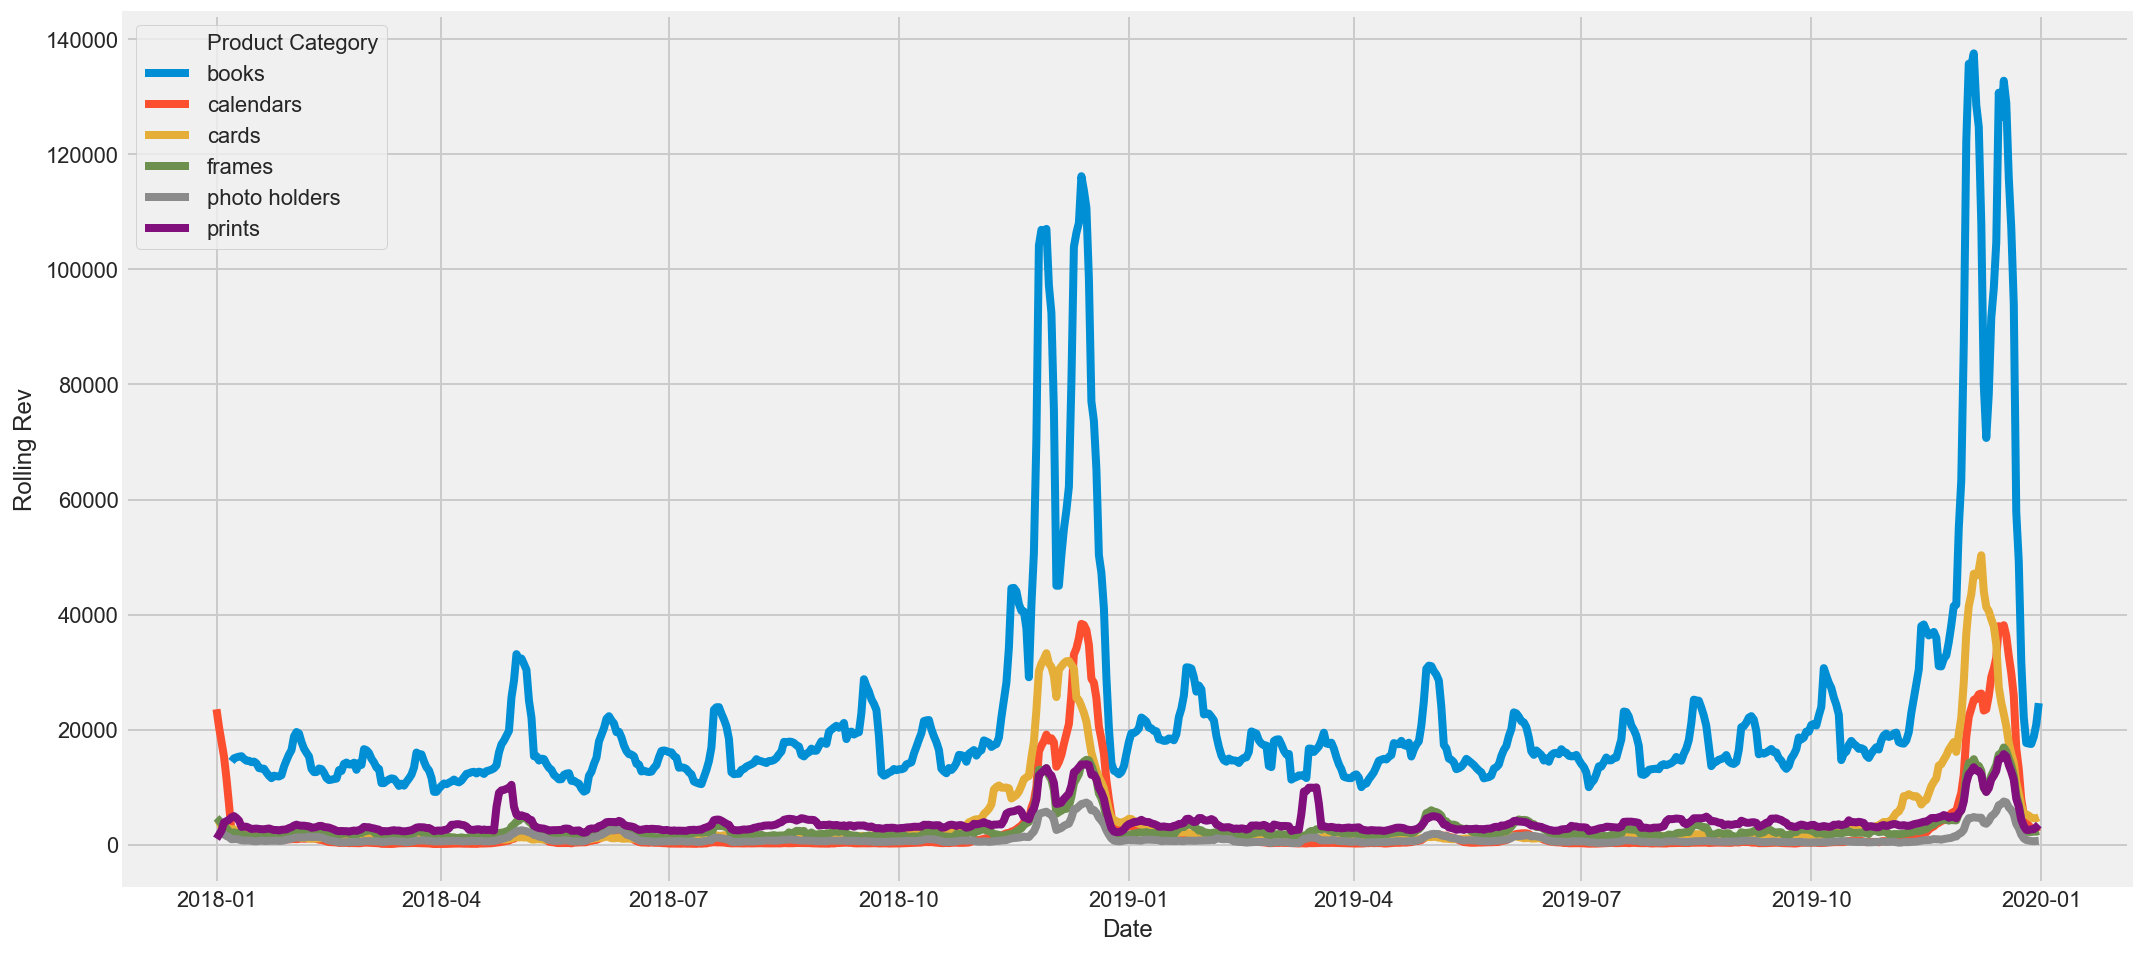

In [30]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='Date',y='Rolling Rev', hue='Product Category', data=daily_rev)

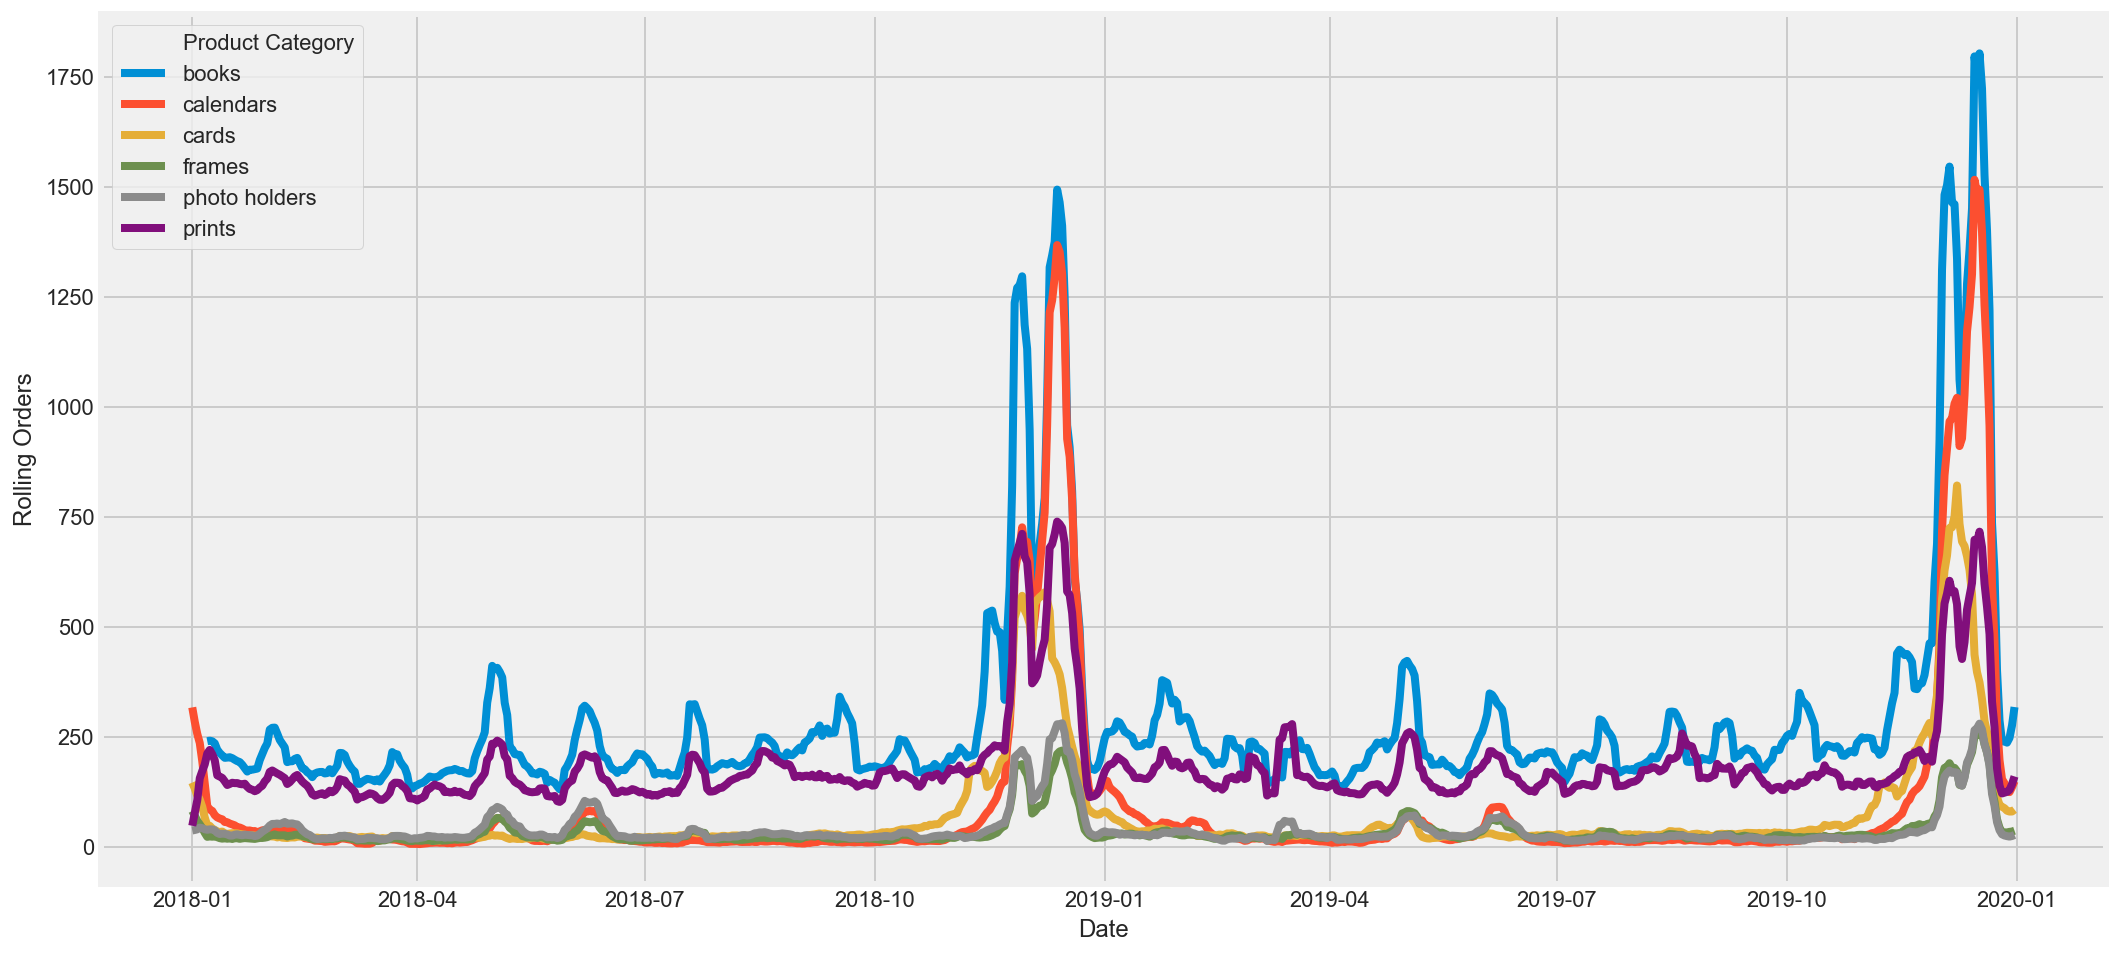

In [31]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='Date',y='Rolling Orders', hue='Product Category', data=daily_orders)

Looks like Calendars and Prints are under performing compared to books 

In [53]:
books_roll_prof = daily_profit[daily_profit['Product Category']=='books'][['Date','Rolling Profit']].set_index('Date').dropna()
prints_roll_prof = daily_profit[daily_profit['Product Category']=='prints'][['Date','Rolling Profit']].set_index('Date').dropna()
cal_roll_prof = daily_profit[daily_profit['Product Category']=='calendars'][['Date','Rolling Profit']].set_index('Date').dropna()

# Season Decomposition

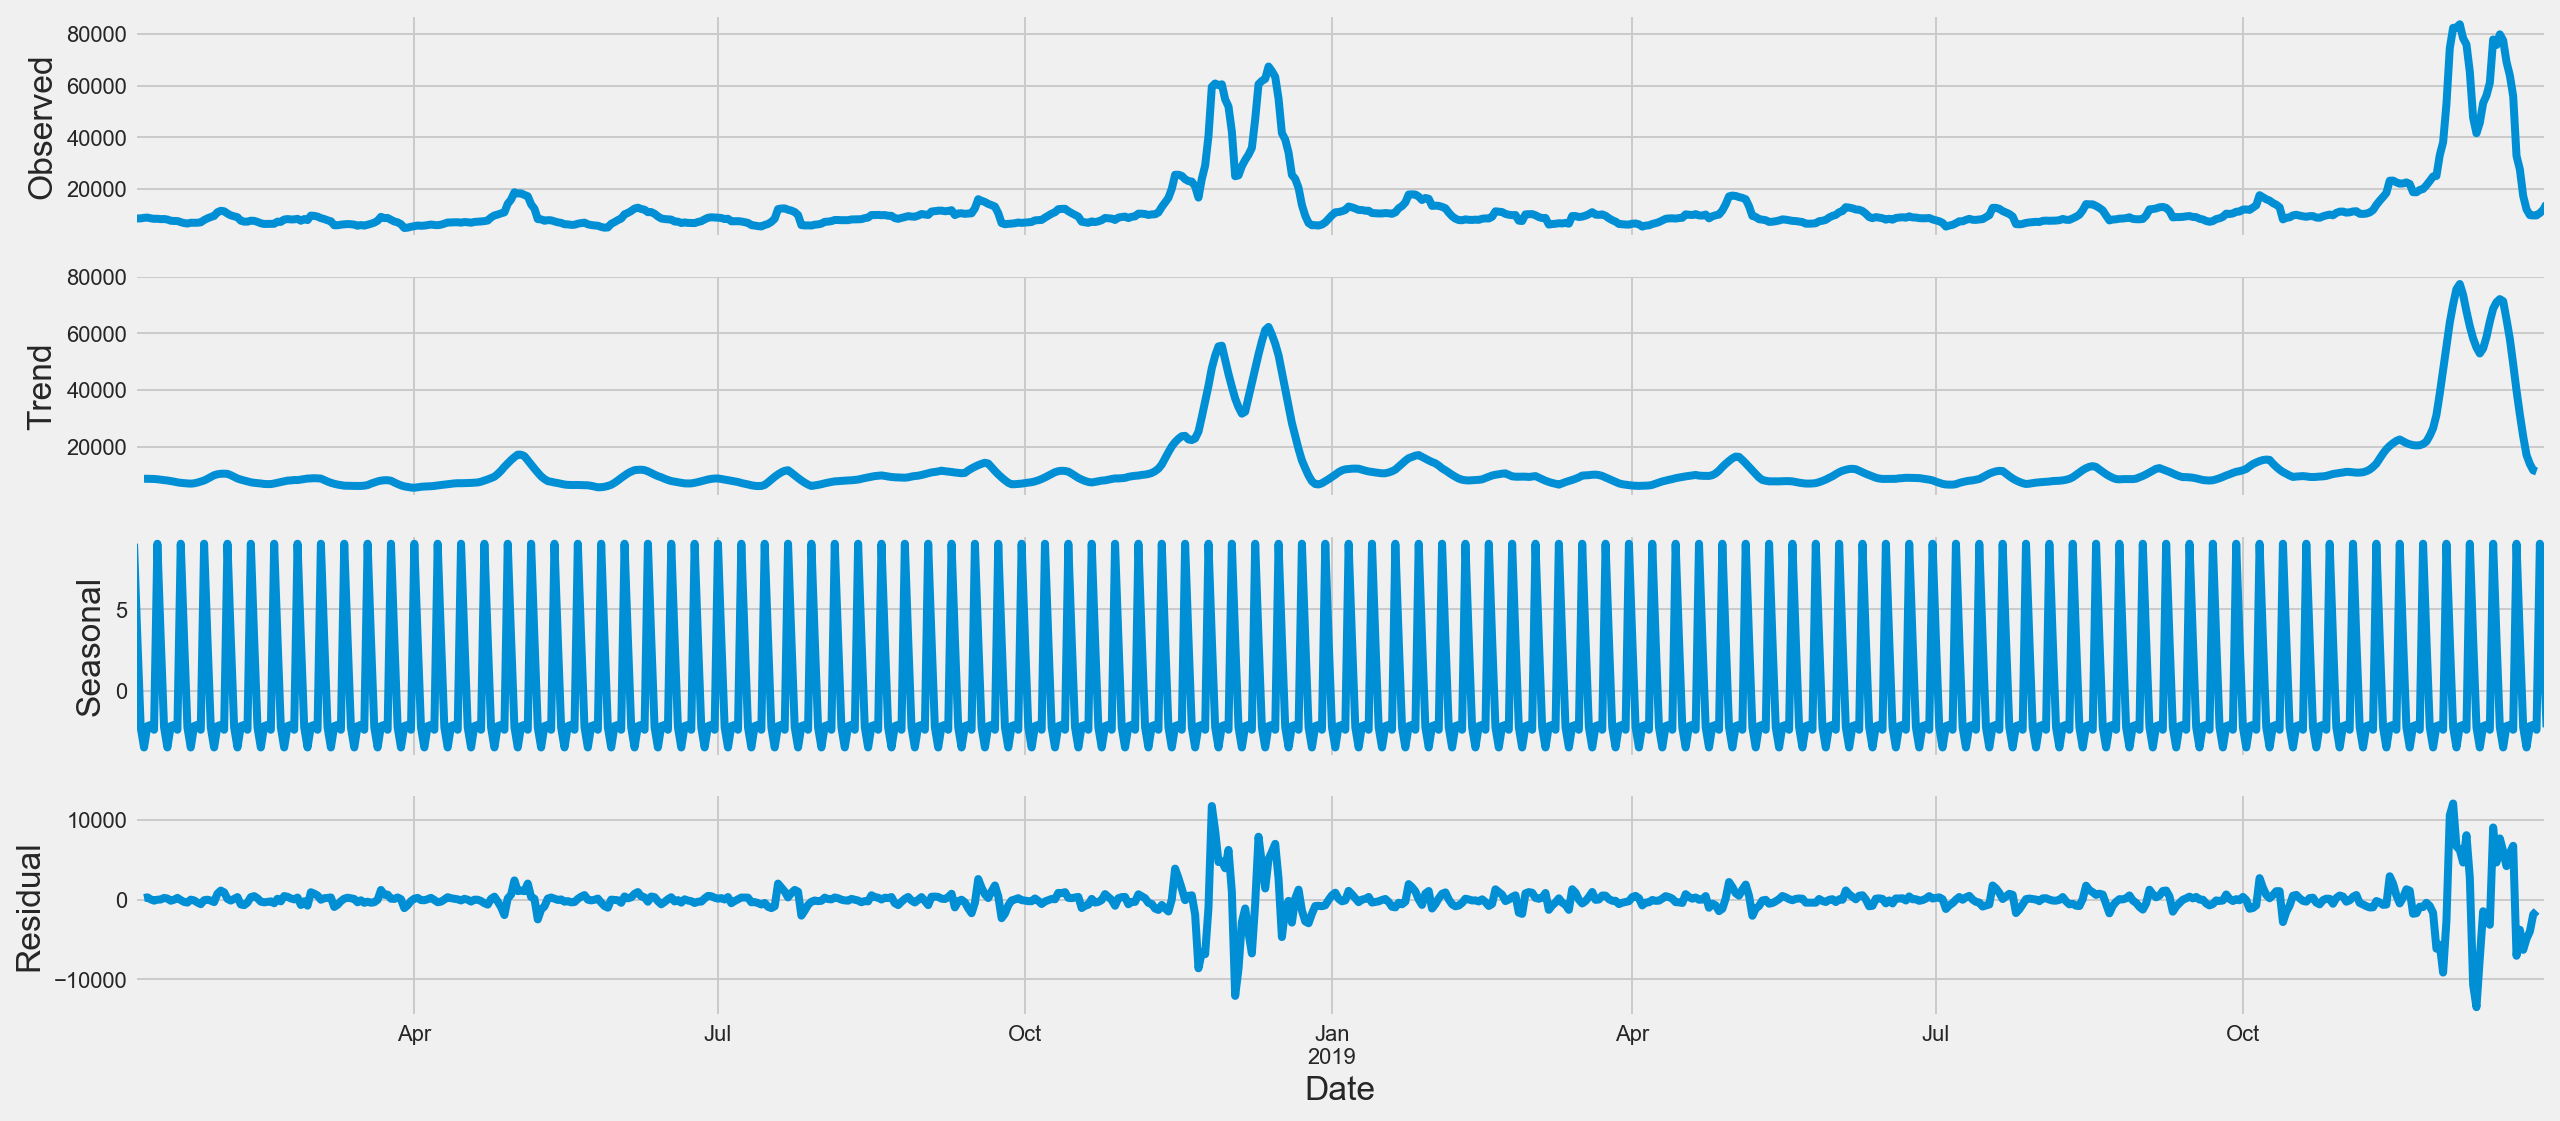

In [54]:
decomposition = sm.tsa.seasonal_decompose(books_roll_prof, model='additive')
rcParams['figure.figsize'] = 18, 8
fig = decomposition.plot()
plt.show()

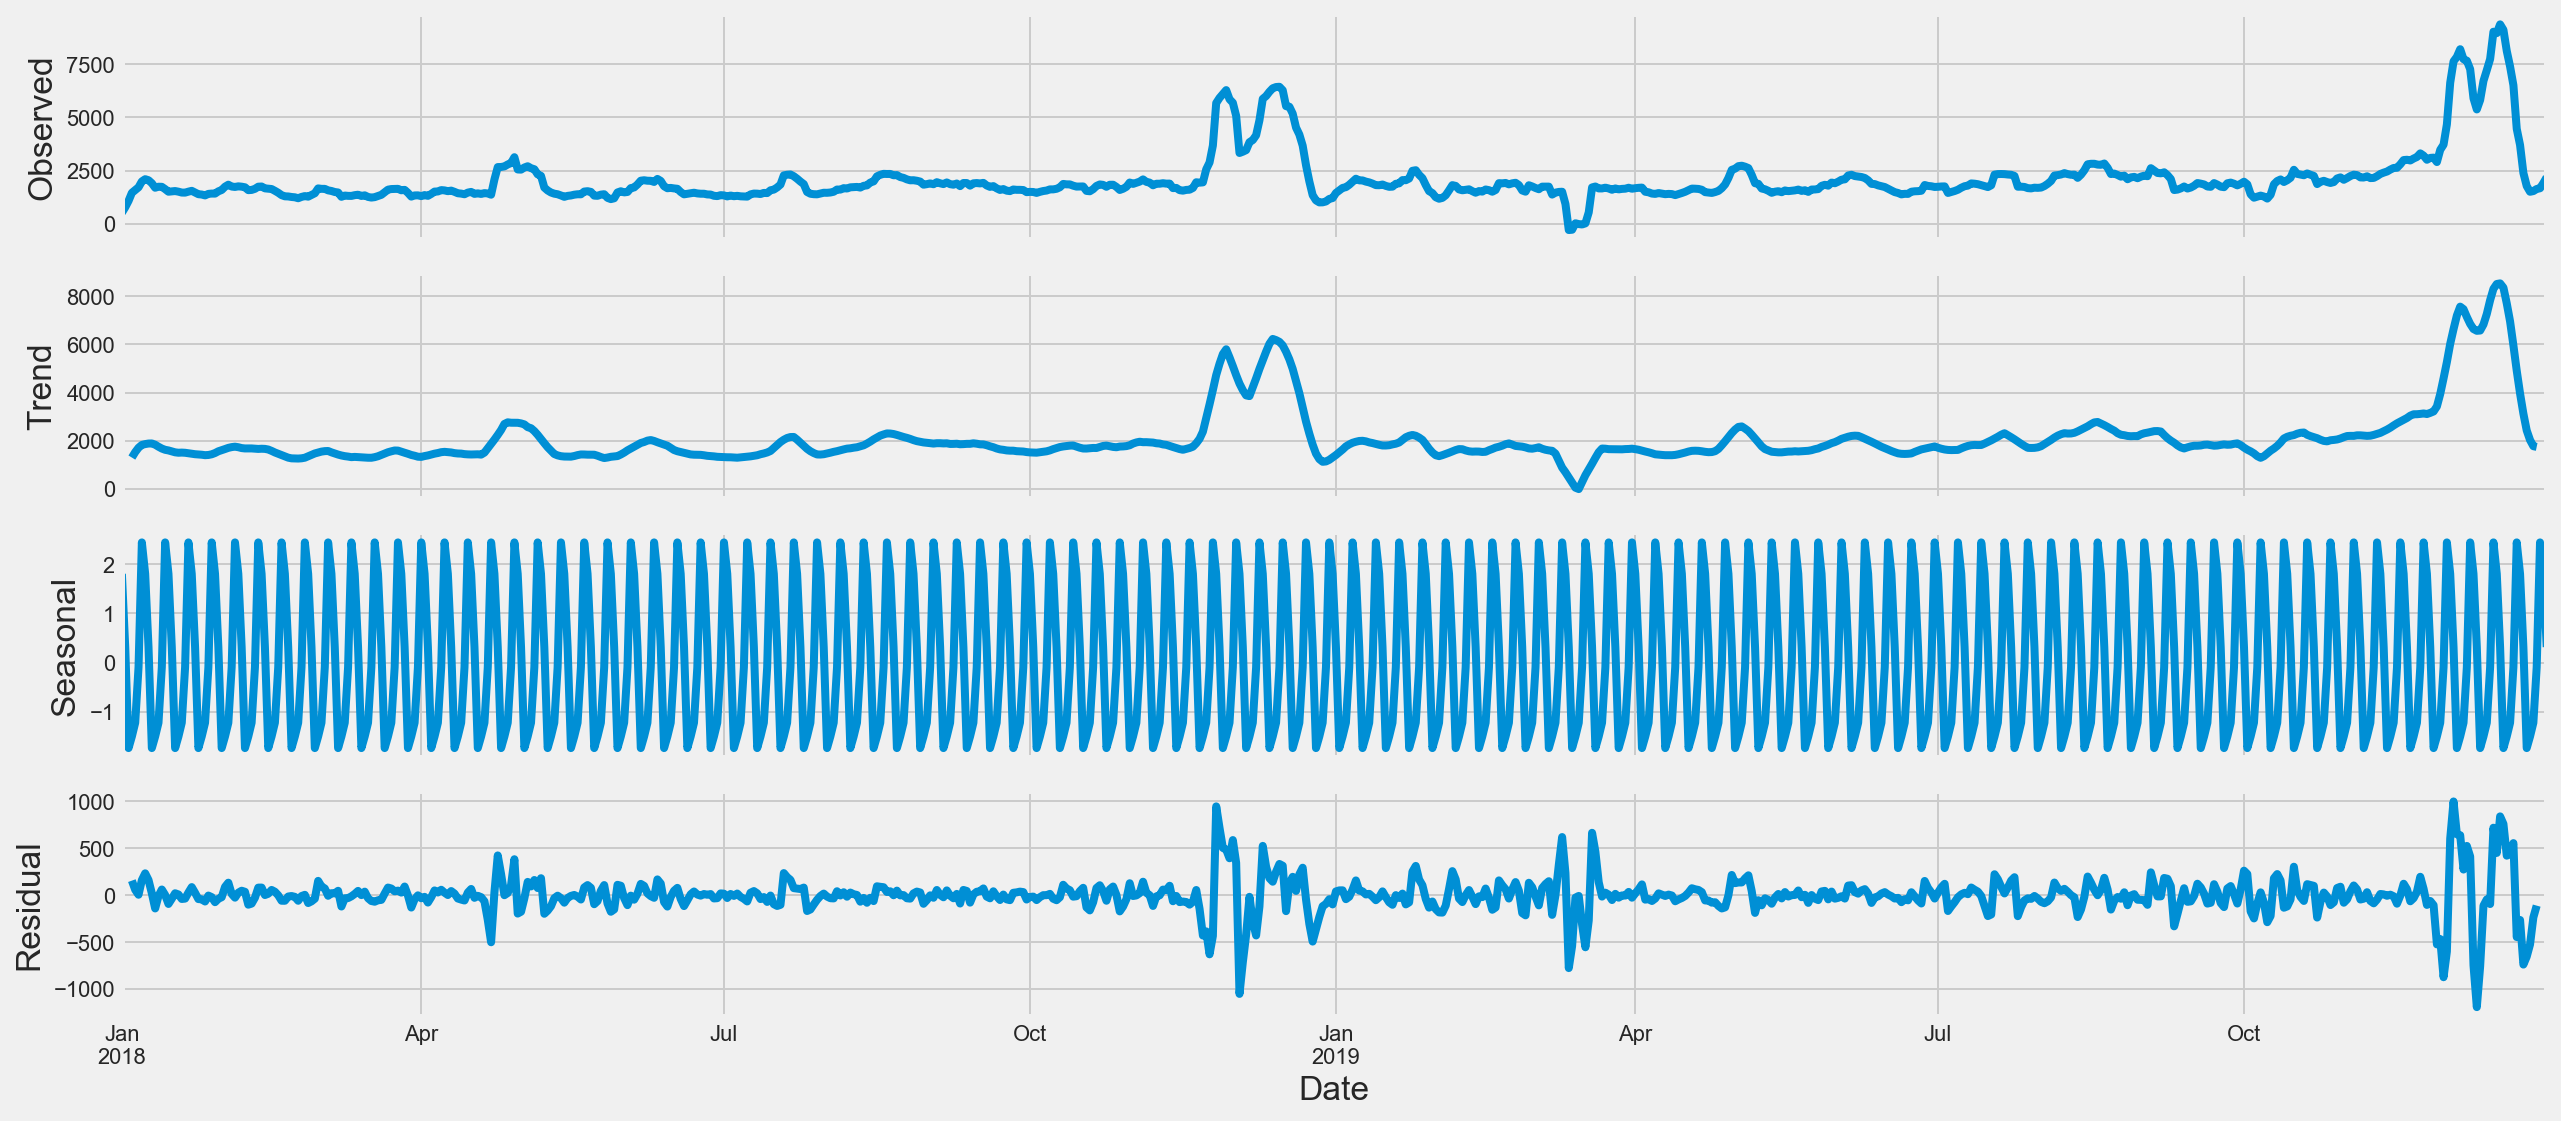

In [40]:
decomposition = sm.tsa.seasonal_decompose(, model='additive')
fig = decomposition.plot()
rcParams['figure.figsize'] = 18, 8
plt.show()

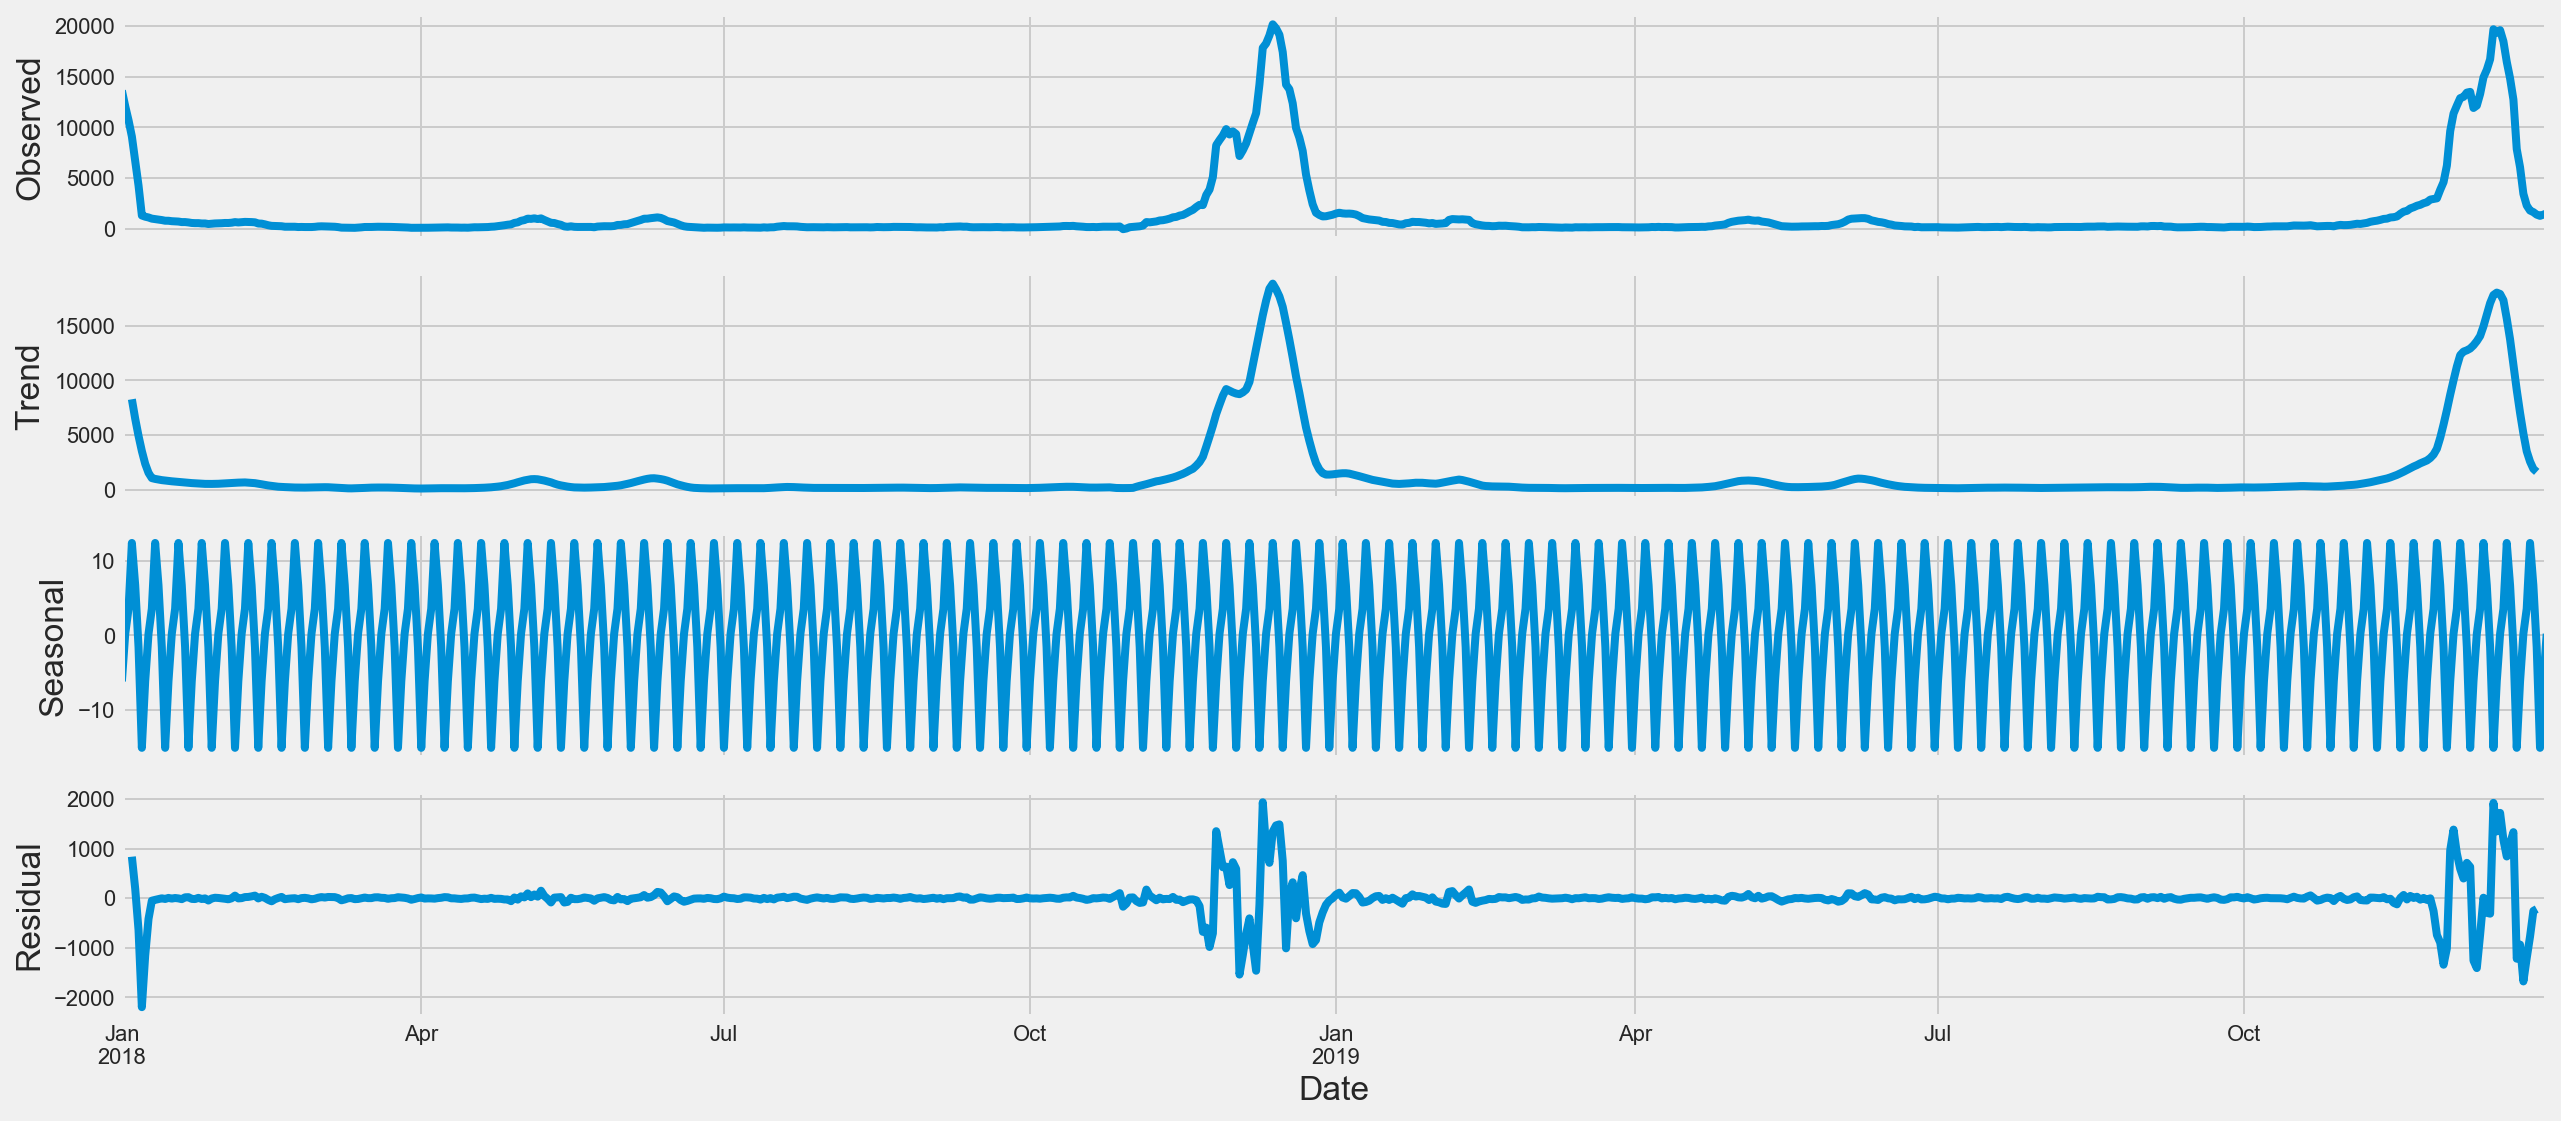

In [43]:
decomposition = sm.tsa.seasonal_decompose(daily_profit[daily_profit['Product Category']=='calendars'][['Date','Rolling Profit']].set_index('Date').dropna(), model='additive')
fig = decomposition.plot()
rcParams['figure.figsize'] = 18, 8
plt.show()

# Augmented Dickey Fuller Test

In [56]:
adfuller(books_roll_prof.iloc[:,0].values)[1]

9.76522388369383e-06

In [57]:
adfuller(prints_roll_prof.iloc[:,0].values)[1]

0.00017725210085326465

In [58]:
adfuller(cal_roll_prof.iloc[:,0].values)[1]

0.00033743658355977357

Seems like there isn't much of a trend and the data is stationary until it hits Q4 and throws everything off. Basically, the analysis wants me to consider the christmas holiday as an outlier. 

In [ ]:
synchrony_test = weekly_orders[weekly_orders['Product Category'].isin(['photo holders','frames','prints'])]
plt.figure(figsize=(16, 8))
sns.lineplot(x='Date',y='Paid Order Count', hue='Product Category', data=synchrony_test)

In [ ]:
r, p = stats.pearsonr(synchrony_test[synchrony_test['Product Category']=='prints']['Paid Order Count'], synchrony_test[synchrony_test['Product Category']=='frames']['Paid Order Count'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

In [ ]:
r, p = stats.pearsonr(synchrony_test[synchrony_test['Product Category']=='photo holders']['Paid Order Count'], synchrony_test[synchrony_test['Product Category']=='frames']['Paid Order Count'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

In [ ]:
r, p = stats.pearsonr(synchrony_test[synchrony_test['Product Category']=='prints']['Paid Order Count'], synchrony_test[synchrony_test['Product Category']=='photo holders']['Paid Order Count'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Conclusion: There's a statistically significant relationship between prints and frames|photo holders. I'm sure this is picking up on the fact that they're already bundling these but worth a look. 

Next Step: Product line analysis - Look for opportunities to change pricing

# Hunt For Under Performing Product Lines in Profitable Categories

In [ ]:
plt.figure(figsize=(16, 8))
sns.barplot(x='Product Category', y='Unit Cost', hue='Year', estimator=np.mean, data=df)

In [ ]:
plt.figure(figsize=(16, 8))
sns.barplot(x='Product Category', y='Paid Order Count', hue='Year', estimator=np.sum, data=df)

In [ ]:
book_profits = df[(df['Year']==2019)&(df['Product Category']=='books')].groupby('Product Line')['Profit'].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(16, 8))
g = sns.barplot(x='Product Line',y='Profit',data=book_profits[:10])
g.set_xticklabels(df[:10]['Product Line'], rotation=90)

In [ ]:
line_profits = df[(df['Year']==2019)&(df['Product Category']=='books')].groupby('Product Line')['Profit'].sum()
book_profit = df[(df['Year']==2019)&(df['Product Category']=='books')]['Profit'].sum()
line_profits.div(book_profit).sort_values(ascending=False)